# Motif K-mer Analysis

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = ".jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
import sklearn
from sklearn import preprocessing
import multiprocessing
import threading
from collections import Counter
import time
from sklearn import decomposition
from numba import jit
### notebook specific configuration ###
%matplotlib inline
sys.path.append("/home/jtao/code/seq_merge_pipe/")
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/kmer_analysis/')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2
%env PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin



env: PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin


## Copy Data 

In [82]:
%%bash
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/summary_frame.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/annotation_frame.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/C57BL6J.fa ./
# background data
cp /gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/C57BL6J_background.fa ./C57BL6J_background.fa 


## Read in Peak and Sequence Data

In [2]:
summary_frame = pd.read_pickle('summary_frame.pickle')
annotation_frame = pd.read_pickle('annotation_frame.pickle')
### read in sequences as dictionary {peakID: sequence}
with open('./C57BL6J.fa') as f:
    data = f.readlines()

target_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        target_sequence_dict[sequenceName] = line.strip().upper()  

## read in background sequences
with open('./C57BL6J_background.fa') as f:
    data = f.readlines()
background_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        background_sequence_dict[sequenceName] = line.strip().upper()[:200]
intersecting_ids = set(target_sequence_dict.keys()).intersection(set(background_sequence_dict.keys()))
for iid in intersecting_ids:
    del background_sequence_dict[iid]

## Read in Motifs

### convert MEME motif database text file into individual motifs



In [3]:
converted_motifs_dir = './individual_motifs/'
if not os.path.isdir(converted_motifs_dir):
    os.mkdir(converted_motifs_dir)
else:
    for f in os.listdir(converted_motifs_dir):
        os.remove(converted_motifs_dir + '/' + f)
        
with open('JASPAR_CORE_2016_vertebrates.meme') as f:
    data = f.readlines()
    
currentLines = [data[9]]
for line in data[9:]:
    if 'MOTIF' in line:
        motifName = currentLines[0].strip().split()[-1]
        outFile = open(converted_motifs_dir + '/' + motifName + '.fimo', 'w')
        outFile.write('MEME version 4.4\n\nALPHABET= ACGT\n\nstrands: + -\n\nBackground letter frequencies (from uniform background):\nA 0.25000 C 0.25000 G 0.25000 T 0.25000 ')
        for cl in currentLines:
            outFile.write(cl)
        outFile.close()
        currentLines = [line]
    else:
        currentLines.append(line)

### Read in individual Motifs

In [4]:
motif_dir = './individual_motifs/'
motif_matrix_dict = {}
for mf in os.listdir(motif_dir):
    with open(motif_dir + '/' + mf) as f:
        data = f.readlines()
    motif_name = data[7].strip().split()[-1]
    freqs = []
    for pwm_line in data[10:-3]:
        tokens = pwm_line.strip().split('\t')
        freqs.append([float(x.strip()) for x in tokens])
    
    motif_matrix_dict[motif_name] = freqs
    

## Construct K-mers

In [5]:
# size of biggest motif
max_size = np.max([len(motif_matrix_dict[x]) for x in motif_matrix_dict.keys()])

In [6]:
threshold = 0.3
z_threshold = 2.0
pos_nuc_dict = dict(zip(range(4),['A', 'C', 'G', 'T']))
max_kmer_size = 10
total_possible_list = []
num_observed_list = []
num_significant_list = []
k_list = []
for kmer_target_length in range(1,max_kmer_size+1):
    print('looking at ' + str(kmer_target_length)+'-mers')
    num_possible = np.power(4,kmer_target_length)
    total_possible_list.append(num_possible)
    k_list.append(kmer_target_length)
    kmers = []
    for motif_name in sorted(motif_matrix_dict.keys()):
        current_motif = motif_matrix_dict[motif_name]
        current_nucs = []
        kmer_length = np.min([len(current_motif), kmer_target_length])
        for pwm_pos in range(len(current_motif)):
            significant_nucs = []
            current_freqs = current_motif[pwm_pos]
            if current_freqs[0] >= threshold:
                significant_nucs.append('A')
            if current_freqs[1] >= threshold:
                significant_nucs.append('C')
            if current_freqs[2] >= threshold:
                significant_nucs.append('G')
            if current_freqs[3] >= threshold:
                significant_nucs.append('T')
            current_nucs.append(significant_nucs)
            if len(current_nucs) == kmer_length:
                current_kmers = itertools.product(*current_nucs)
                for km in current_kmers:
                    kmers.append(''.join(km))
                current_nucs = current_nucs[1:] # increment sliding window
    numObserved = len(set(kmers))
    motif_counts = Counter(kmers)
    count_values = list(motif_counts.values())
    zscores = scipy.stats.zscore(count_values)
    numSignificant = np.sum(zscores>=z_threshold)
    print('shapiro p-val:',scipy.stats.shapiro(count_values)[1])
    num_observed_list.append(numObserved)
    num_significant_list.append(numSignificant)

looking at 1-mers
shapiro p-val: 0.2889775037765503
looking at 2-mers
shapiro p-val: 0.04585282504558563
looking at 3-mers
shapiro p-val: 5.743105793953873e-05
looking at 4-mers
shapiro p-val: 1.0469322595851722e-16
looking at 5-mers
shapiro p-val: 3.2724102647838156e-40
looking at 6-mers
shapiro p-val: 0.0
looking at 7-mers
shapiro p-val: 0.0
looking at 8-mers
shapiro p-val: 0.0
looking at 9-mers
shapiro p-val: 0.0
looking at 10-mers
shapiro p-val: 0.0


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/scipy/stats/morestats.py:1329: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


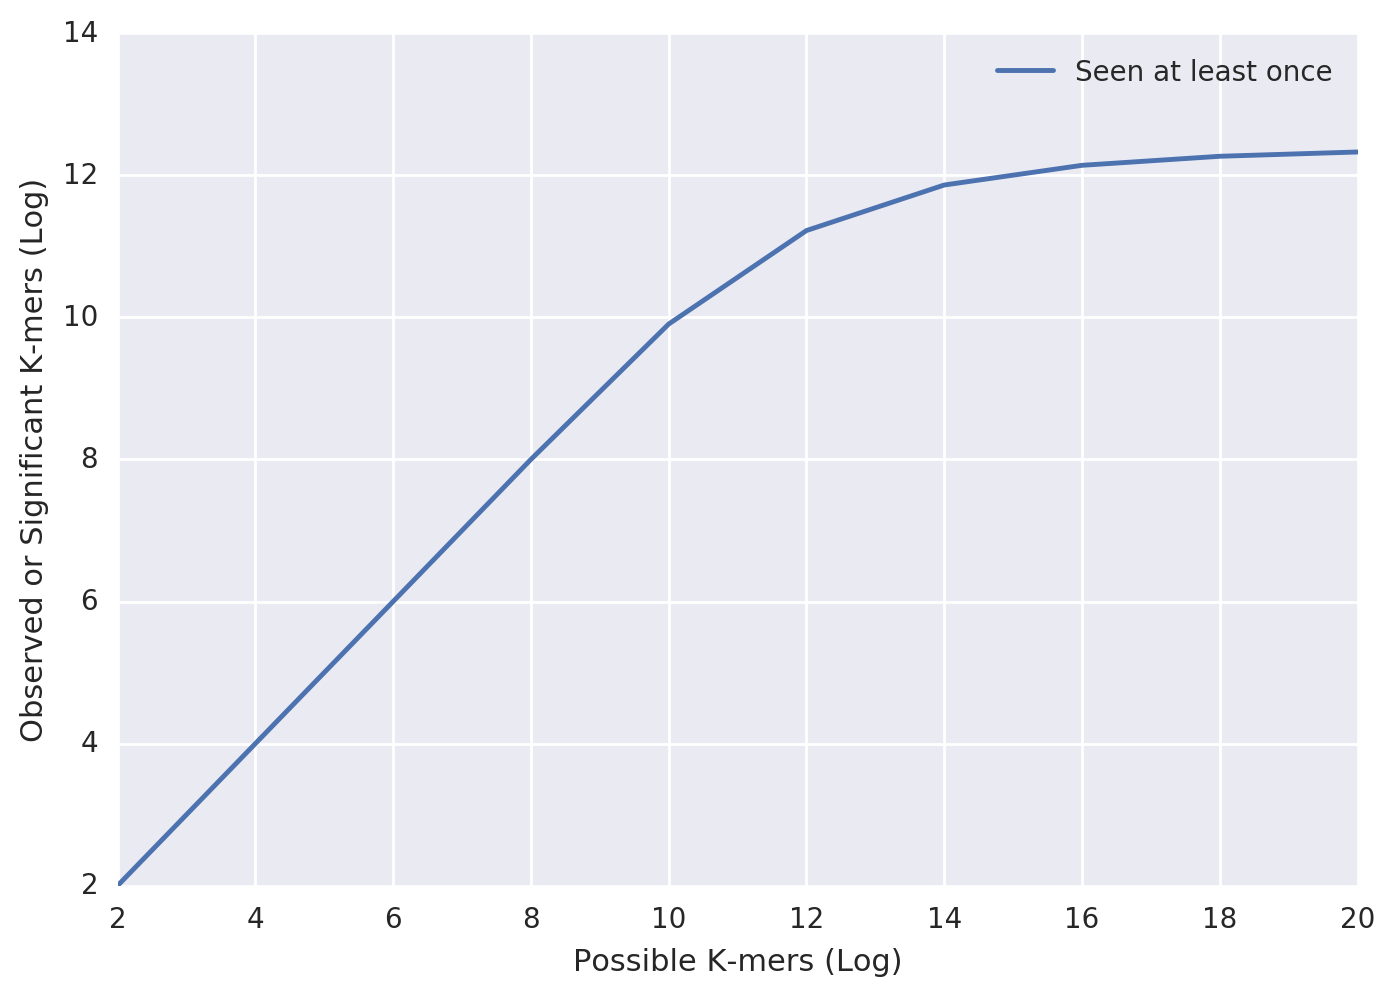

In [7]:
plt.plot(np.log2(total_possible_list), 
         np.log2(num_observed_list),
         label='Seen at least once'
            )
# plt.plot(np.log2(total_possible_list), 
#             np.log2(num_significant_list),
#             label='Signficant')
plt.legend()
plt.xlabel('Possible K-mers (Log)')
plt.ylabel('Observed or Significant K-mers (Log)')


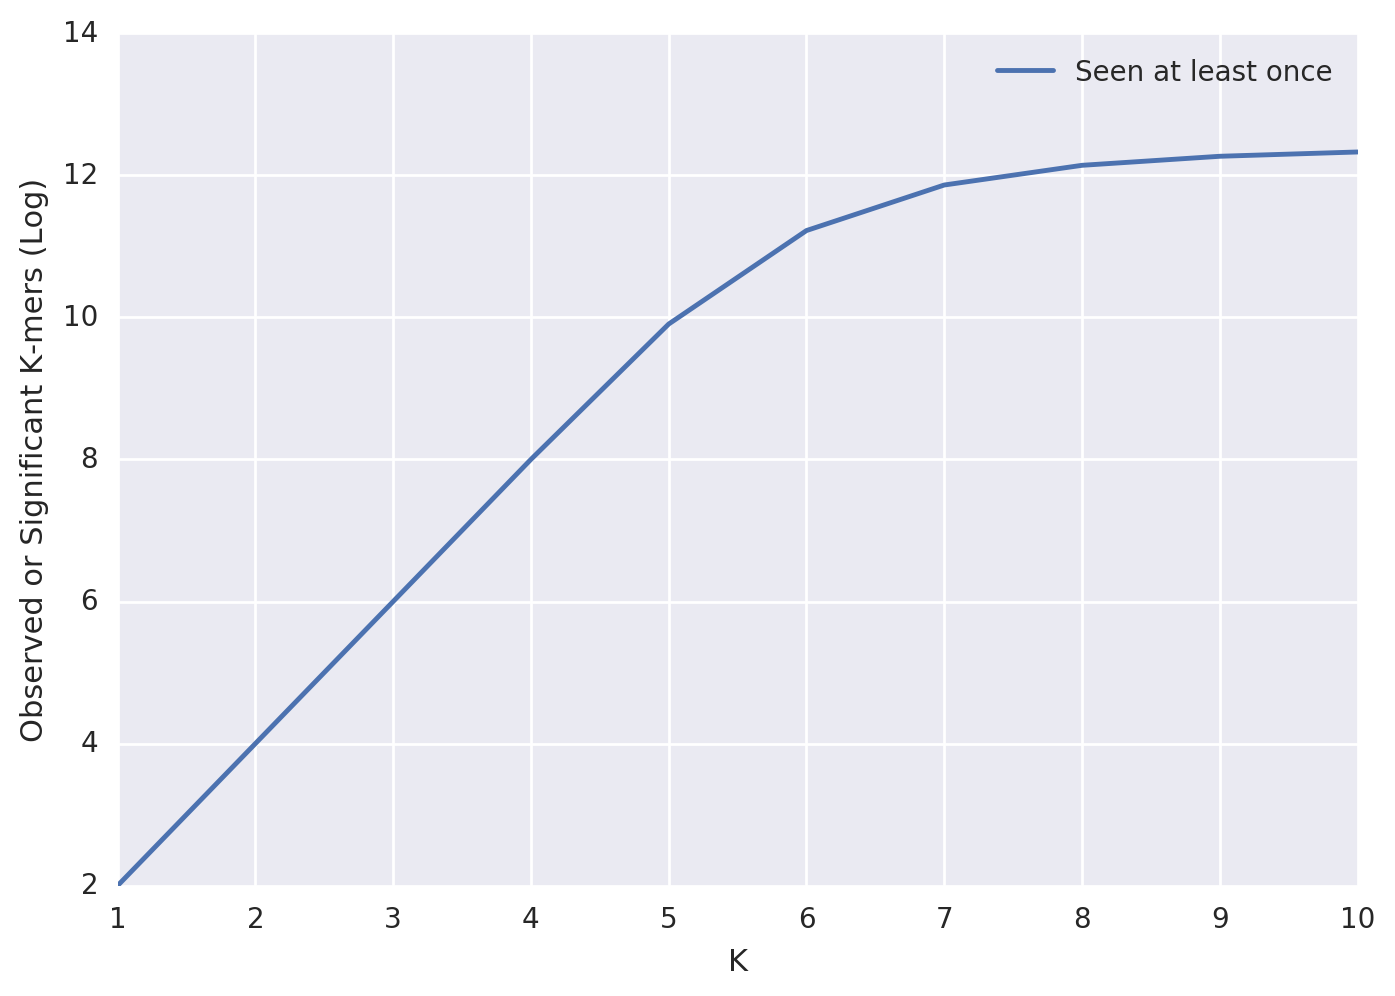

In [8]:
plt.plot(k_list, 
         np.log2(num_observed_list),
         label='Seen at least once'
            )
# plt.plot(k_list, 
#             np.log2(num_significant_list),
#             label='Signficant')
plt.legend()
plt.xlabel('K')
plt.ylabel('Observed or Significant K-mers (Log)')

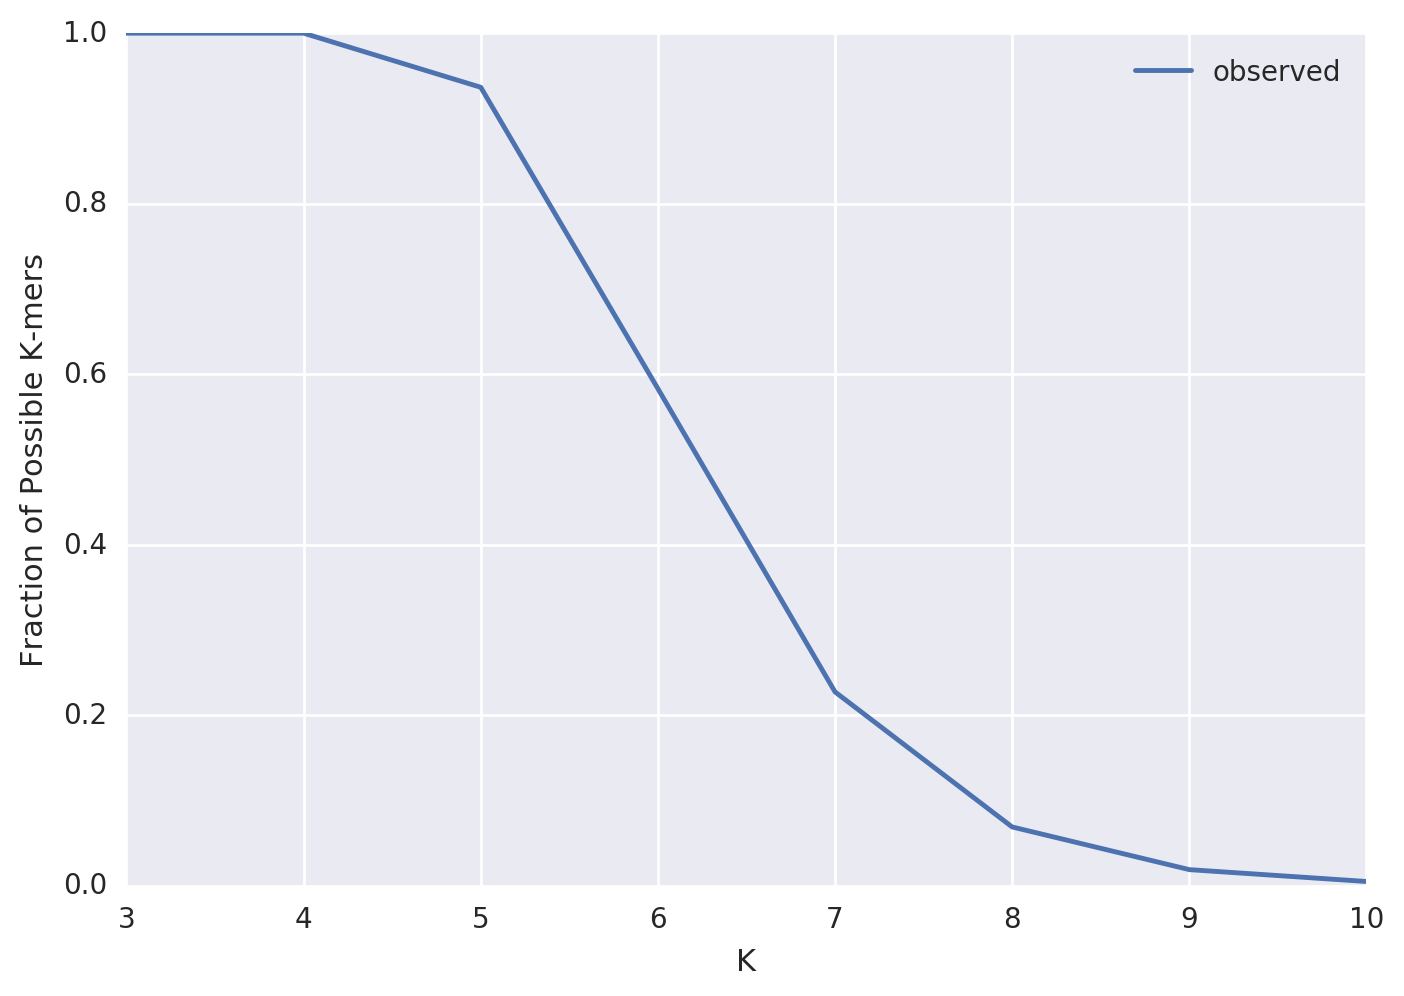

In [9]:
observed_fractions = np.array(num_observed_list)/np.array(total_possible_list)
significant_fractions = np.array(num_significant_list)/np.array(total_possible_list)
plt.plot(k_list, 
         observed_fractions,
         label='observed'
            )
# plt.plot(k_list, 
#          significant_fractions,
#          label='significant'
#             )
plt.legend()
plt.xlim(3,10)
plt.xlabel('K')
plt.ylabel('Fraction of Possible K-mers')



/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


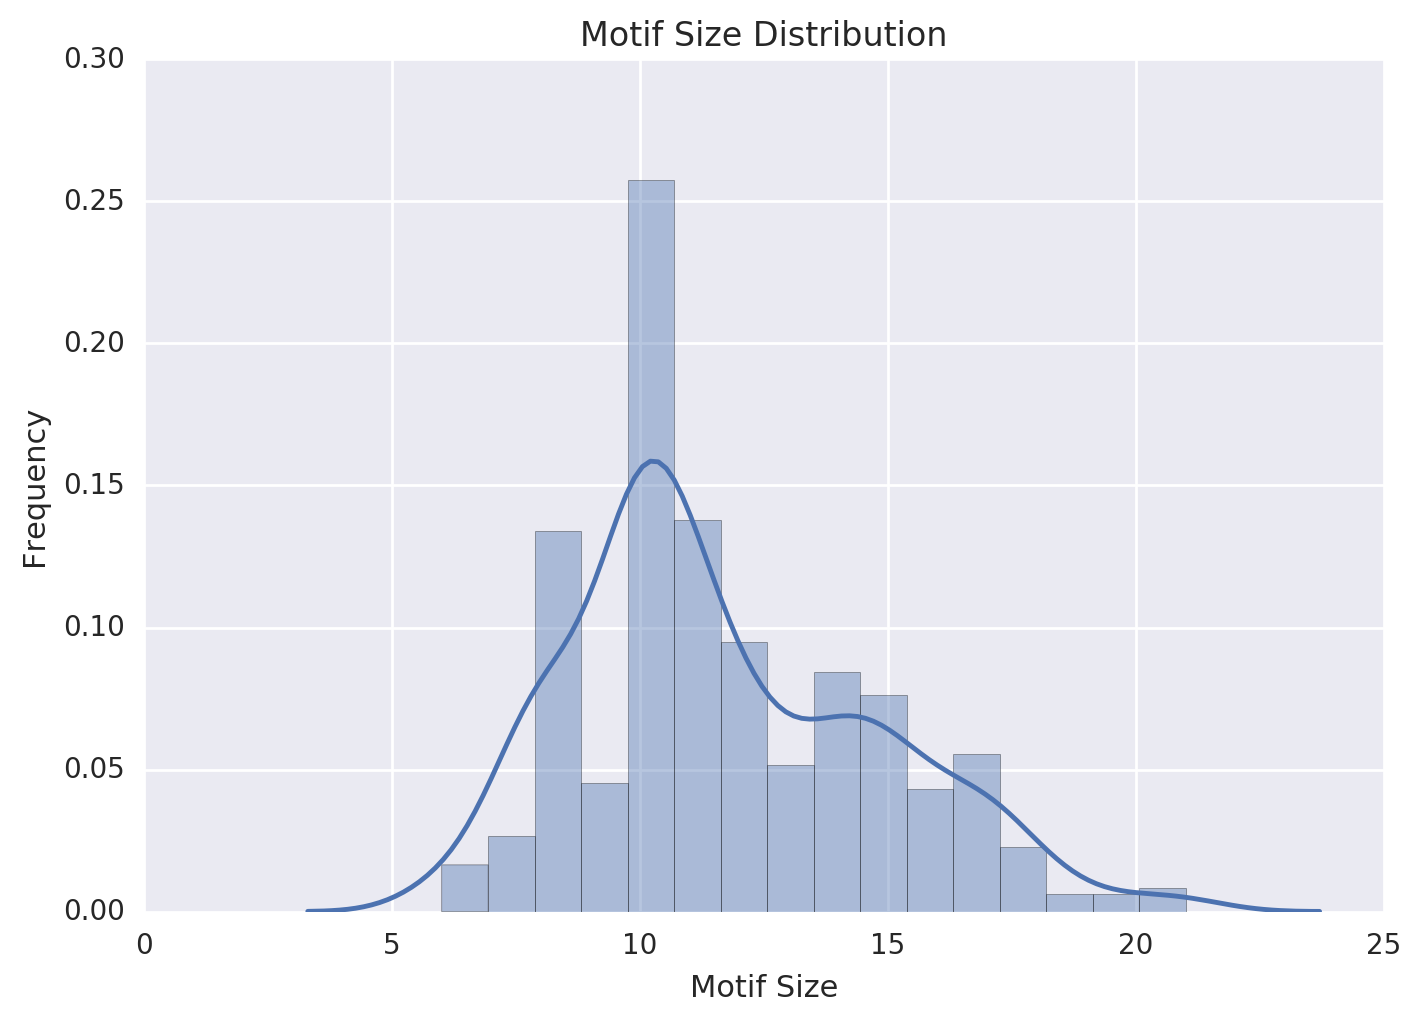

In [10]:
sns.distplot([len(motif_matrix_dict[x]) for x in motif_matrix_dict.keys()])
plt.ylabel('Frequency')
plt.xlabel('Motif Size')
plt.title('Motif Size Distribution')

## Distribution of K-mer counts

In [25]:
threshold = 0.3
pos_nuc_dict = dict(zip(range(4),['A', 'C', 'G', 'T']))
max_kmer_size = 10
count_list = []
k_list = []
normed_count_list = []
total_kmers= []

for kmer_target_length in range(1,max_kmer_size+1):
    print('looking at ' + str(kmer_target_length)+'-mers')
    num_possible = np.power(4,kmer_target_length)
    total_kmers.append(num_possible)
    kmers = []
    for motif_name in sorted(motif_matrix_dict.keys()):
        current_motif = motif_matrix_dict[motif_name]
        current_nucs = []
        kmer_length = np.min([len(current_motif), kmer_target_length])
        for pwm_pos in range(len(current_motif)):
            significant_nucs = []
            current_freqs = current_motif[pwm_pos]
            if current_freqs[0] >= threshold:
                significant_nucs.append('A')
            if current_freqs[1] >= threshold:
                significant_nucs.append('C')
            if current_freqs[2] >= threshold:
                significant_nucs.append('G')
            if current_freqs[3] >= threshold:
                significant_nucs.append('T')
            current_nucs.append(significant_nucs)
            if len(current_nucs) == kmer_length:
                current_kmers = itertools.product(*current_nucs)
                for km in current_kmers:
                    kmers.append(''.join(km))
                current_nucs = current_nucs[1:] # increment sliding window
    motif_counts = Counter(kmers)
    count_values = list(motif_counts.values())
    k_list = k_list + [kmer_target_length] * len(count_values)
    count_list = count_list + count_values
    normed_count_list = normed_count_list + list(scipy.stats.zscore(count_values))

looking at 1-mers
looking at 2-mers
looking at 3-mers
looking at 4-mers
looking at 5-mers
looking at 6-mers
looking at 7-mers
looking at 8-mers
looking at 9-mers
looking at 10-mers


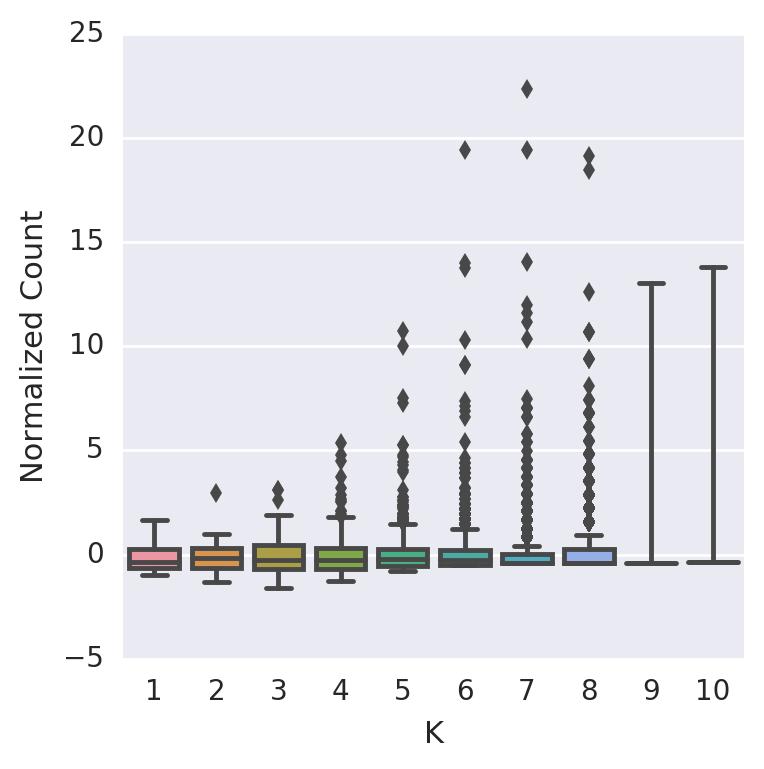

In [29]:
frame = pd.DataFrame({'K':k_list,
                     'Count':count_list,
                     'Normalized Count':normed_count_list,
                      'Log Count':np.log2(np.array(count_list) + 1)
                      })
sns.factorplot(data = frame, 
             x = 'K',
             y = 'Normalized Count',
             kind='box')

## Inferring K-mer Order Maps

In [30]:
def calculate_orderMap(seq, 
                       k,
                       kmer_index_dict,
                       window_overlap = 0,
                       interaction_distance = 200,
                       verbose = False
                       ):
    num_kmers = len(kmer_index_dict)
    interaction_matrix = np.zeros((num_kmers,num_kmers))
    if verbose:
        print('reading', seq, len(seq))
    seenKmers = [] # ordered list of k-mers encountered
    for frame in range(k):
        if verbose:
            print('frame', frame)
        move_increment = (k - window_overlap)
        numWindows = int(np.floor((len(seq) - k - frame)/move_increment)) + 1
        if verbose:
            print('numWindows', numWindows)
        for i in range(numWindows):
            startingPos =  frame + i * move_increment
            currentKmer = seq[startingPos:startingPos + k]
            if verbose:
                print(startingPos, startingPos + k, currentKmer)
            if not 'N' in currentKmer:
                # update interaction matrix
                for skmt in seenKmers:
                    skm = skmt[0]
                    skm_start = skmt[1]
                    # if the seen k-mer follows the current k-mer
                    if skm_start < startingPos:
                        distance = startingPos - (skm_start + k)
                        if distance <= interaction_distance and distance >= ( -1 *window_overlap):
                            skm_index = kmer_index_dict[skm] # row index
                            currentKmer_index = kmer_index_dict[currentKmer] # col index
                            interaction_matrix[skm_index][currentKmer_index] +=1
                            if verbose:
                                print(skm, '->', currentKmer, distance)
                # update seenKmers
                seenKmers.append((currentKmer, startingPos))
    
    return interaction_matrix


In [31]:
# @jit(nopython=False,cache=True)
# def calculate_orderMap_numba(seq, 
#                        k,
#                        kmer_index_dict,
#                        window_overlap = 0,
#                        interaction_distance = 200,
#                        verbose = False
#                        ):
#     num_kmers = len(kmer_index_dict)
#     interaction_matrix = np.zeros((num_kmers,num_kmers), dtype=np.int32)
#     seenKmers = None # ordered list of k-mers encountered
#     for frame in range(k):
#         move_increment = (k - window_overlap)
#         numWindows = int(np.floor((len(seq) - k - frame)/move_increment)) + 1
#         for i in range(numWindows):
#             startingPos =  frame + i * move_increment
#             currentKmer = seq[startingPos:startingPos + k]
#             if not 'N' in currentKmer:
#                 # update interaction matrix
#                 if not seenKmers == None:
#                     for skmt in seenKmers:
#                         skm = skmt[0]
#                         skm_start = skmt[1]
#                         # if the seen k-mer follows the current k-mer
#                         if skm_start < startingPos:
#                             distance = startingPos - (skm_start + k)
#                             if distance <= interaction_distance and distance >= ( -1 *window_overlap):
#                                 skm_index = kmer_index_dict[skm] # row index
#                                 currentKmer_index = kmer_index_dict[currentKmer] # col index
#                                 interaction_matrix[skm_index][currentKmer_index] +=1
#                 # update seenKmers
#                     seenKmers.append((currentKmer, startingPos))
#                 else:
#                     seenKmers = [(currentKmer, startingPos)]


#     return interaction_matrix



In [32]:
def calculate_kmerOrderMap(id_sequence_dict, 
                           k, 
                           window_overlap = 0,
                           interaction_distance = 200,
                           verbose=False,
                           create_pickle = False,
                           pickle_prefix = None):
    ids = sorted(id_sequence_dict.keys())
    sequences = [id_sequence_dict[x] for x in ids]
    orderMaps = []
    print(interaction_distance, window_overlap)
    # initialize kmer indices
    kmer_index_dict = {}
    counter = 0
    for kmer in itertools.product(['A', 'C', 'G', 'T'], repeat=k):
        kmer_string = ''.join(kmer)
        kmer_index_dict[kmer_string] = counter
        counter += 1
    # loop through sequences
    for seq in sequences:
        orderMap = calculate_orderMap(seq,
                                      k,
                                      kmer_index_dict,
                                      window_overlap = window_overlap,
                                      interaction_distance = interaction_distance,
                                      verbose=verbose)
        orderMaps.append(orderMap)
    if create_pickle and not pickle_prefix == None:
        print('writing pickle file', interaction_distance, window_overlap)
        pickle.dump(orderMaps, open(pickle_prefix + '_orderMaps.pickle', 'wb'))
        pickle.dump(ids, open(pickle_prefix + '_ids.pickle', 'wb'))
    return ids, orderMaps, kmer_index_dict

### Timing Tests with Order Maps

In [118]:
# test_dict = dict(zip(range(3),['AAACCCGGGTTT', # 3-mers no overlap
#                   'AAAACCCGGGTTT', # for 3-mers second frame \
#                   'ATATATATATAT' # 3-mers  1 overlap
#                   ]))
test_dict = dict(zip(range(1),['AAACCCGGGTTT', # 3-mers no overlap
                 
                  ]))

In [34]:
numseq_list = []
numproc_list = []
time_list = []
for numSequences in [1, 10, 100, 1000]:
    peak_indices = summary_frame[summary_frame['c57bl6_atf3_veh'] > 0.0].index.values[:numSequences]
    peak_sequences = [target_sequence_dict[x] for x in peak_indices]
    background_indices = list(background_sequence_dict.keys())[:len(peak_indices)]
    background_sequences = [background_sequence_dict[x][:numSequences] for x in background_indices]

    test_dict = dict(zip(np.concatenate([peak_indices, background_indices]),
                    np.concatenate([peak_sequences, background_sequences])))
    start = time.time()
    ids, orderMaps, kmer_index_dict = calculate_kmerOrderMap(test_dict, 
                           k=3, 
                           window_overlap = 0,
                           interaction_distance = 10,
                           verbose = False
                           )
    end = time.time()
    numseq_list.append(numSequences)
    time_list.append(end-start)
    print(end-start, numSequences)

10 0
0.003346681594848633 1
10 0
0.031275272369384766 10
10 0
0.40912961959838867 100
10 0
6.31087327003479 1000


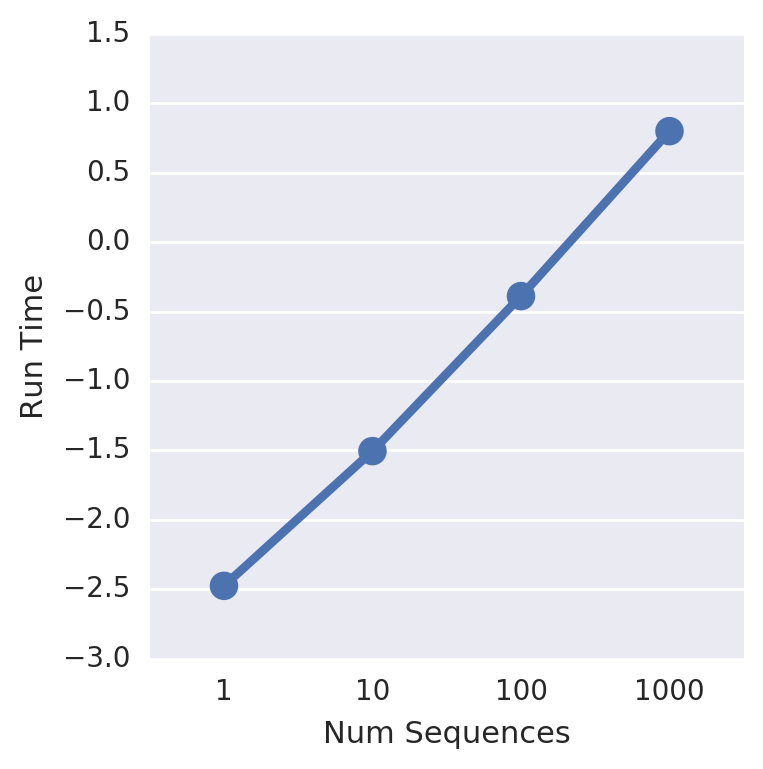

In [35]:
time_frame = pd.DataFrame({'Run Time': np.log10(np.array(time_list)),
                           'Num Sequences': numseq_list})
sns.factorplot(data = time_frame,
               x = 'Num Sequences',
               y = 'Run Time',
              )


# Order Maps

### K=3, window_overlap=0, interaction_distance=1

In [380]:
target_ids, current_target_order_maps, kmer_index_dict = calculate_kmerOrderMap(target_sequence_dict, 
                           k=3, 
                           window_overlap = 0,
                           interaction_distance = 1,
                           verbose = False
                           )

current_background_sequence_dict = {x:background_sequence_dict[x] for x in list(background_sequence_dict.keys())[:len(target_sequence_dict)]}

background_ids, background_order_maps, kmer_index_dict = calculate_kmerOrderMap(current_background_sequence_dict, 
                           k=3, 
                           window_overlap = 0,
                           interaction_distance = 1,
                           verbose = False
                           )

In [431]:
# flatten maps and combine target and background sequences
flattened_dict = {}
for i in range(len(target_order_maps)):
    current_id = target_ids[i]
    flattened_dict[current_id] = target_order_maps[i].flatten()
for i in range(len(background_order_maps)):
    current_id = background_ids[i]
    flattened_dict[current_id] = background_order_maps[i].flatten()

index_kmer_dict = {kmer_index_dict[x]:x for x in kmer_index_dict}

flatIndex_transition_dict = {}
transition_flatIndex_dict = {}
counter = 0
for i in range(len(kmer_index_dict)):
    for j in range(len(kmer_index_dict)):
        kmer1 = index_kmer_dict[i]
        kmer2 = index_kmer_dict[j]
        flatIndex_transition_dict[counter] = kmer1 + '->' + kmer2
        transition_flatIndex_dict[kmer1 + '->' + kmer2] = counter
        counter += 1
        
transition_frame = pd.DataFrame(flattened_dict).T
transition_frame.columns = [flatIndex_transition_dict[x] for x in transition_frame.columns.values]

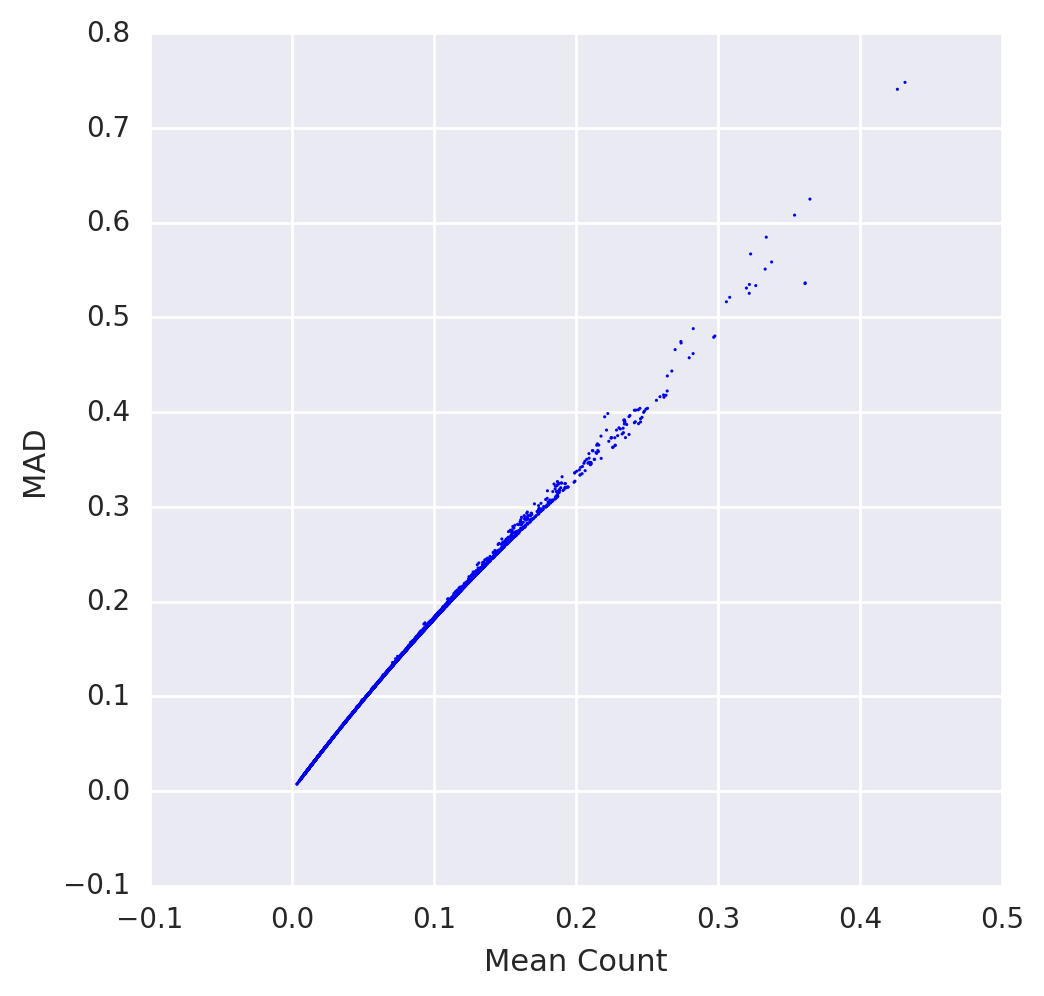

In [392]:
means = transition_frame.mean(axis=0)
mads = transition_frame.mad(axis=0)
labels = transition_frame.index.values

plt.scatter(means,
            mads,
            marker = '.',
            edgecolor = 'None',
            s = 5
           )
# for i in range(len(means)):
#     if means[i] > mads[i]:
#         plt.annotate(xy=(means[i], mads[i]), s=labels[i])
# plt.plot([0,1],[0,1])
# plt.xlim(0,1)
# plt.ylim(0,1)
plt.xlabel('Mean Count')
plt.ylabel('MAD')
ax = plt.gca()
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
# plt.text(x=0.0, y=-0.2, s='No transition enriched when looking at entire data set - no bias', size=10)



#### PCA on all data

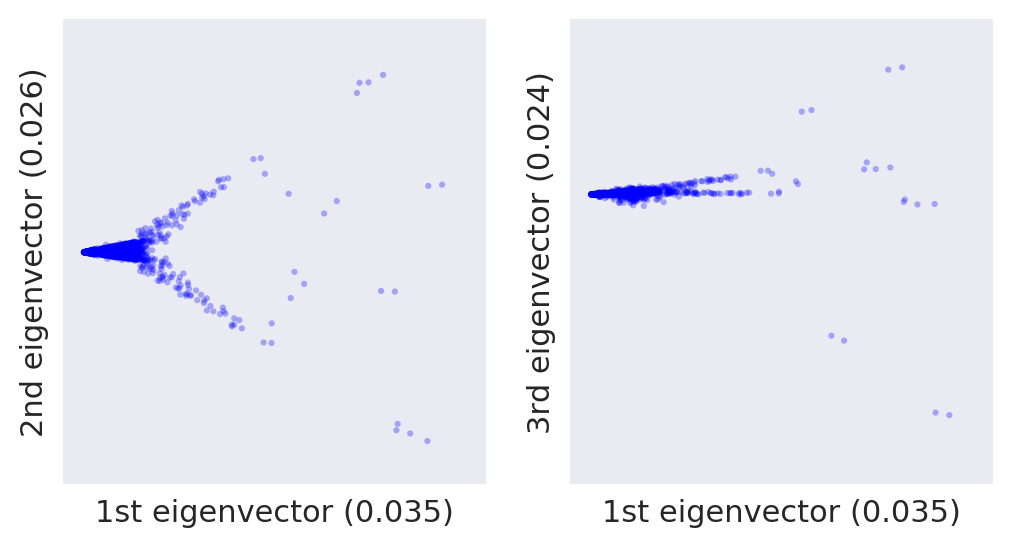

In [390]:
features = transition_frame
# colors = ['red'] * numSequences + ['blue'] * numSequences

model = sklearn.decomposition.PCA()
reduced_features = model.fit_transform(features.T)
explained_variance_ratios = model.explained_variance_ratio_

f, axs = plt.subplots(1,2, figsize=(6,3))
plt.subplot(1,2,1)  
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], s=5, c=colors, edgecolor='None', alpha=0.3)

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])

plt.subplot(1,2,2)  
plt.scatter(reduced_features[:, 0], reduced_features[:, 2], s=5, c=colors, edgecolor='None', alpha=0.3)
plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')
plt.yticks([])
plt.show()

#### PCA on all transitions for each factor

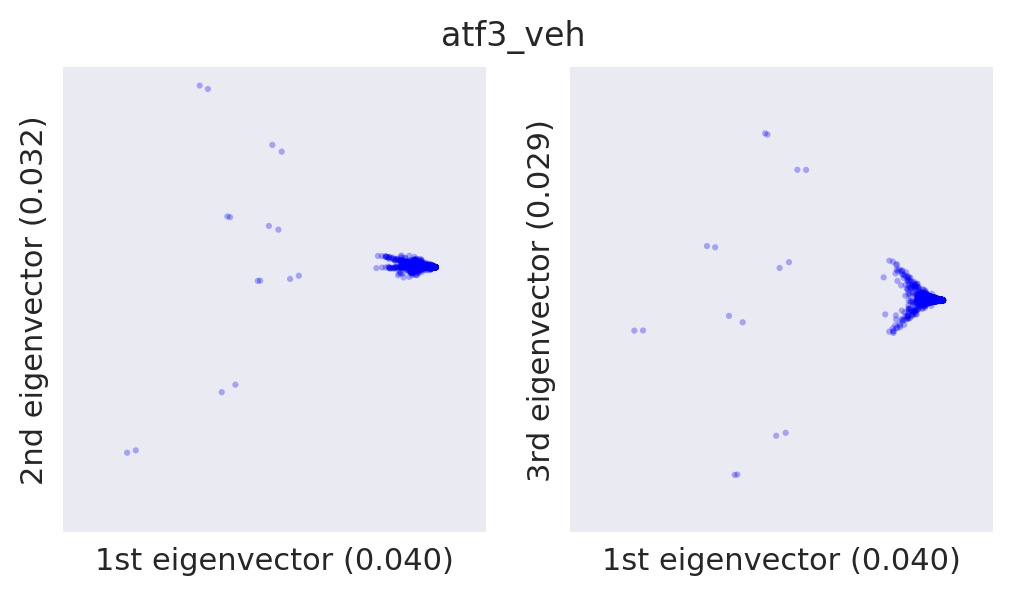

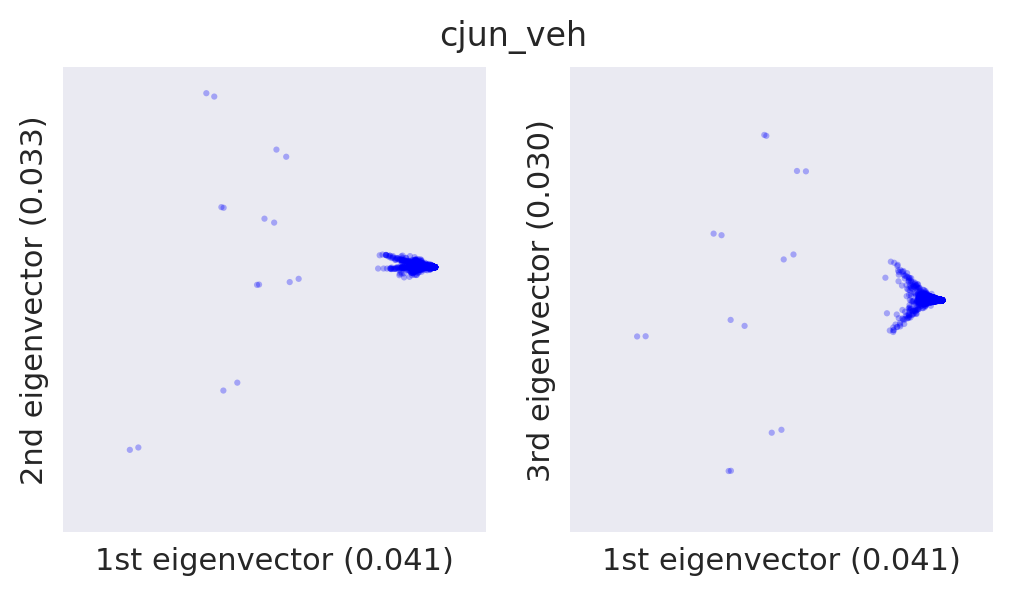

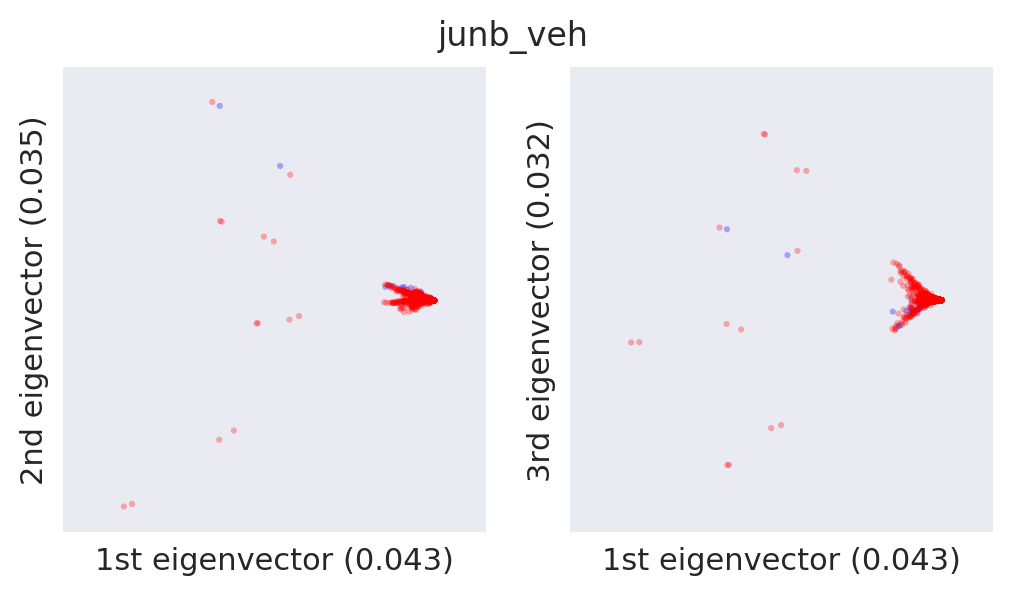

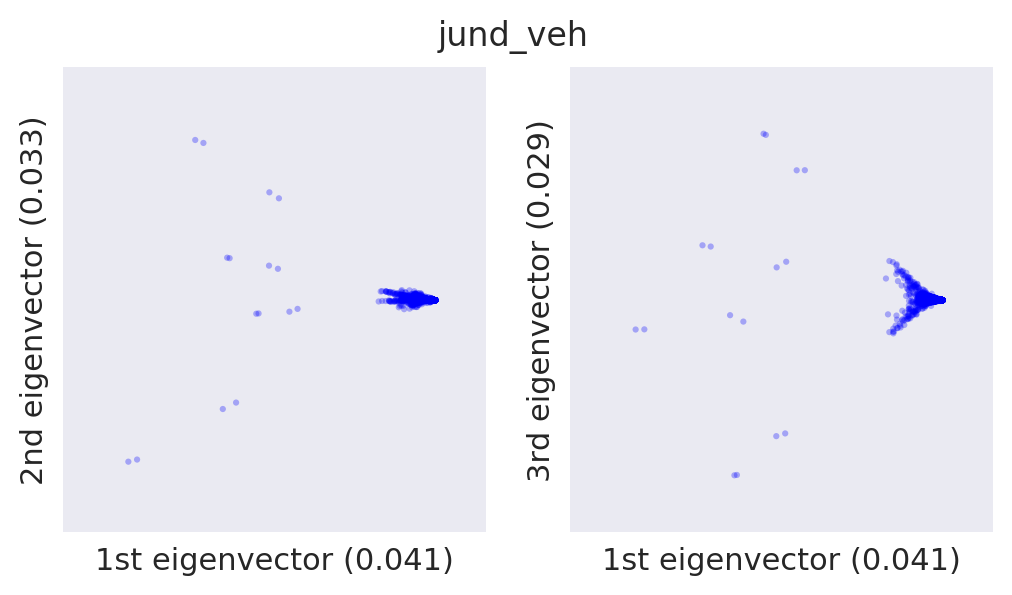

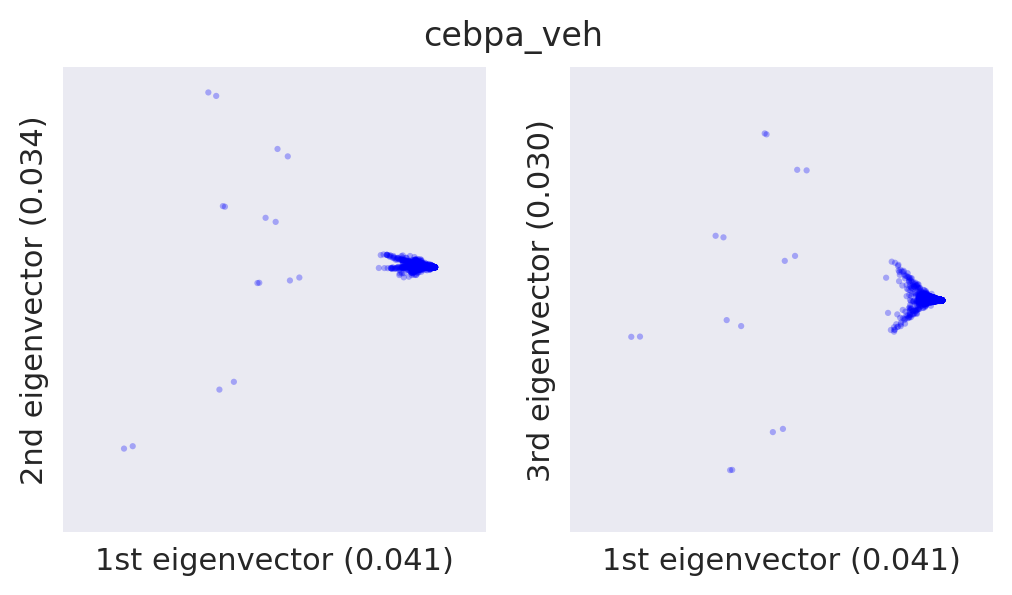

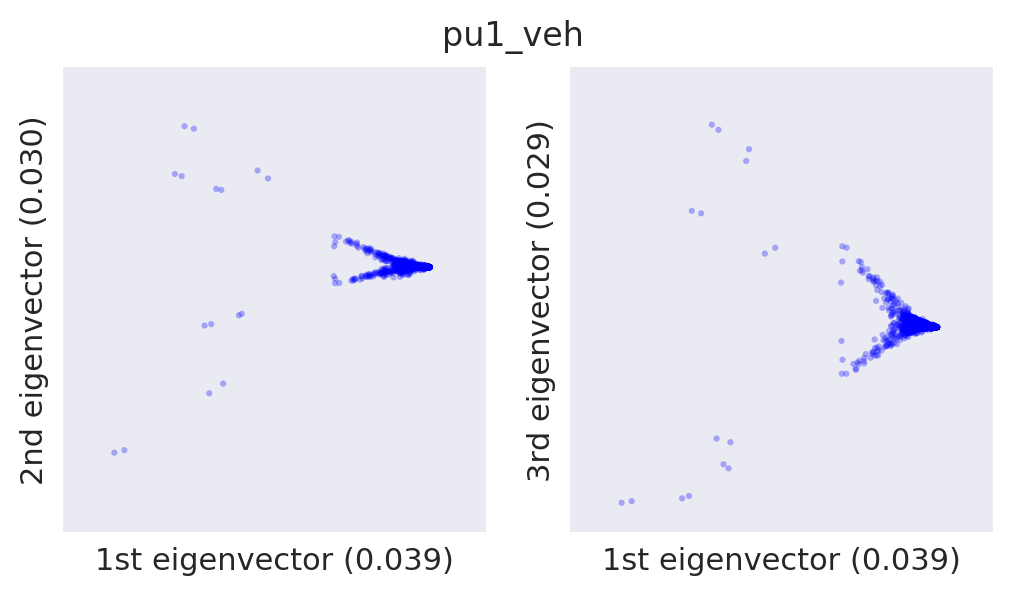

In [388]:
for factor in ['atf3', 'cjun', 'junb', 'jund', 'cebpa', 'pu1']:
    for treatment in ['veh']:
        current_target_ids = summary_frame[summary_frame['c57bl6_' + factor + '_' + treatment] > 0.0].index.values
        
        target_features = transition_frame[transition_frame.index.isin(current_target_ids)]
        background_features = transition_frame[transition_frame.index.isin(background_ids)]
        features = pd.concat([target_features, background_features])
        
        model = sklearn.decomposition.PCA()
        reduced_features = model.fit_transform(features.T)
        explained_variance_ratios = model.explained_variance_ratio_
        
        colors = ['blue' if x in target_features.index.values else 'red' for x in features.index.values]
        f, axs = plt.subplots(1,2, figsize=(6,3))
        plt.subplot(1,2,1)  
        plt.scatter(reduced_features[:, 0], reduced_features[:, 1], s=5, c=colors, edgecolor='None', alpha=0.3)

        plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
        plt.xticks([])
        plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
        plt.yticks([])

        plt.subplot(1,2,2)  
        plt.scatter(reduced_features[:, 0], reduced_features[:, 2], s=5, c=colors, edgecolor='None', alpha=0.3)
        plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
        plt.xticks([])
        plt.ylabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')
        plt.yticks([])
        plt.suptitle(factor + '_' + treatment)
        plt.show()

### Mean vs MAD comparison

In [404]:
# for each monomer in each condition, are there any transition with a mean count that exceeds the MAD?
# looks like no...
for factor in ['atf3', 'cjun', 'fos', 'junb', 'jund', 'cebpa', 'pu1']:
    for treatment in ['veh', 'kla']:
        current_target_ids = summary_frame[summary_frame['c57bl6_' + factor + '_' + treatment] > 0.0].index.values
        
        target_features = transition_frame[transition_frame.index.isin(current_target_ids)]
        background_features = transition_frame[transition_frame.index.isin(background_ids)]
        
        target_mads = target_features.mad(axis=0)
        target_means = target_features.mean(axis=0)
        
        print(np.sum(target_means > target_mads))



0
0
0
0
0
0
0
0
0
0
0
0
0
0


### Kruskal 2 sample test - factor vs random background

In [440]:
# ks two sample tests on target counts vs background counts

p_threshold = 0.01/transition_frame.shape[1]
p_threshold = 1e-100
factor_pval_dict = {}
for factor in ['atf3', 'cjun', 'fos', 'junb', 'jund', 'cebpa', 'pu1']:
    for treatment in ['veh', 'kla']:
# for factor in ['atf3']:
#     for treatment in ['veh']:
        print(factor, treatment)
        pvals = []
        current_target_ids = summary_frame[summary_frame['c57bl6_' + factor + '_' + treatment] > 0.0].index.values
        
        target_features = transition_frame[transition_frame.index.isin(current_target_ids)]
        background_features = transition_frame[transition_frame.index.isin(background_ids)]
        
        for transition in target_features.columns.values:
            target_counts = target_features[transition].values
            background_counts = background_features[transition].values
            stat, pval = scipy.stats.ks_2samp(target_counts, background_counts)
            pvals.append(pval)
            if pval < p_threshold:
                print(transition, pval)
        factor_pval_dict[factor+ '_' + treatment] = pvals
kruskal_frame = pd.DataFrame(factor_pval_dict)
kruskal_frame.index = transition_frame.columns.values


atf3 veh
ACT->TCC 1.80414804554e-304
AGG->AAG 2.09559080435e-267
AGT->CAC 1.84186416167e-128
ATG->ACT 1.7385134016e-102
CTT->CCT 1.97296380421e-269
GAC->TCA 0.0
GAG->GAA 1.68282854568e-125
GAG->TCA 0.0
GGA->AGT 1.55862253574e-294
GTG->ACT 2.31772877886e-137
TGA->CTC 2.63155226776e-303
TGA->GTC 0.0
TGA->TCA 0.0
TTC->CTC 1.70982977419e-148
atf3 kla
ACT->TCC 0.0
AGG->AAG 6.82137380115e-277
AGT->CAC 1.64605519118e-210
AGT->CAT 4.44142861287e-210
ATG->ACT 3.0901452972e-212
ATG->AGT 7.46579300435e-111
CTT->CCT 3.50411890108e-256
GAA->TGA 1.63882828918e-101
GAC->TCA 0.0
GAG->GAA 4.55047479673e-129
GAG->TCA 0.0
GGA->AGT 0.0
GTG->ACT 8.09061361945e-221
TCA->TTC 4.77789628868e-102
TGA->CTC 0.0
TGA->GTC 0.0
TGA->TCA 0.0
TTC->CTC 6.51907915325e-155
cjun veh
ACT->TCC 6.64007267837e-207
AGG->AAG 8.5038814817e-191
AGT->CAC 1.40222852052e-109
CTT->CCT 1.59937649873e-188
GAC->TCA 0.0
GAG->TCA 0.0
GGA->AGT 1.12114425468e-203
GTG->ACT 1.33945886608e-123
TGA->CTC 7.31811412398e-305
TGA->GTC 0.0
TGA->TCA 0

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


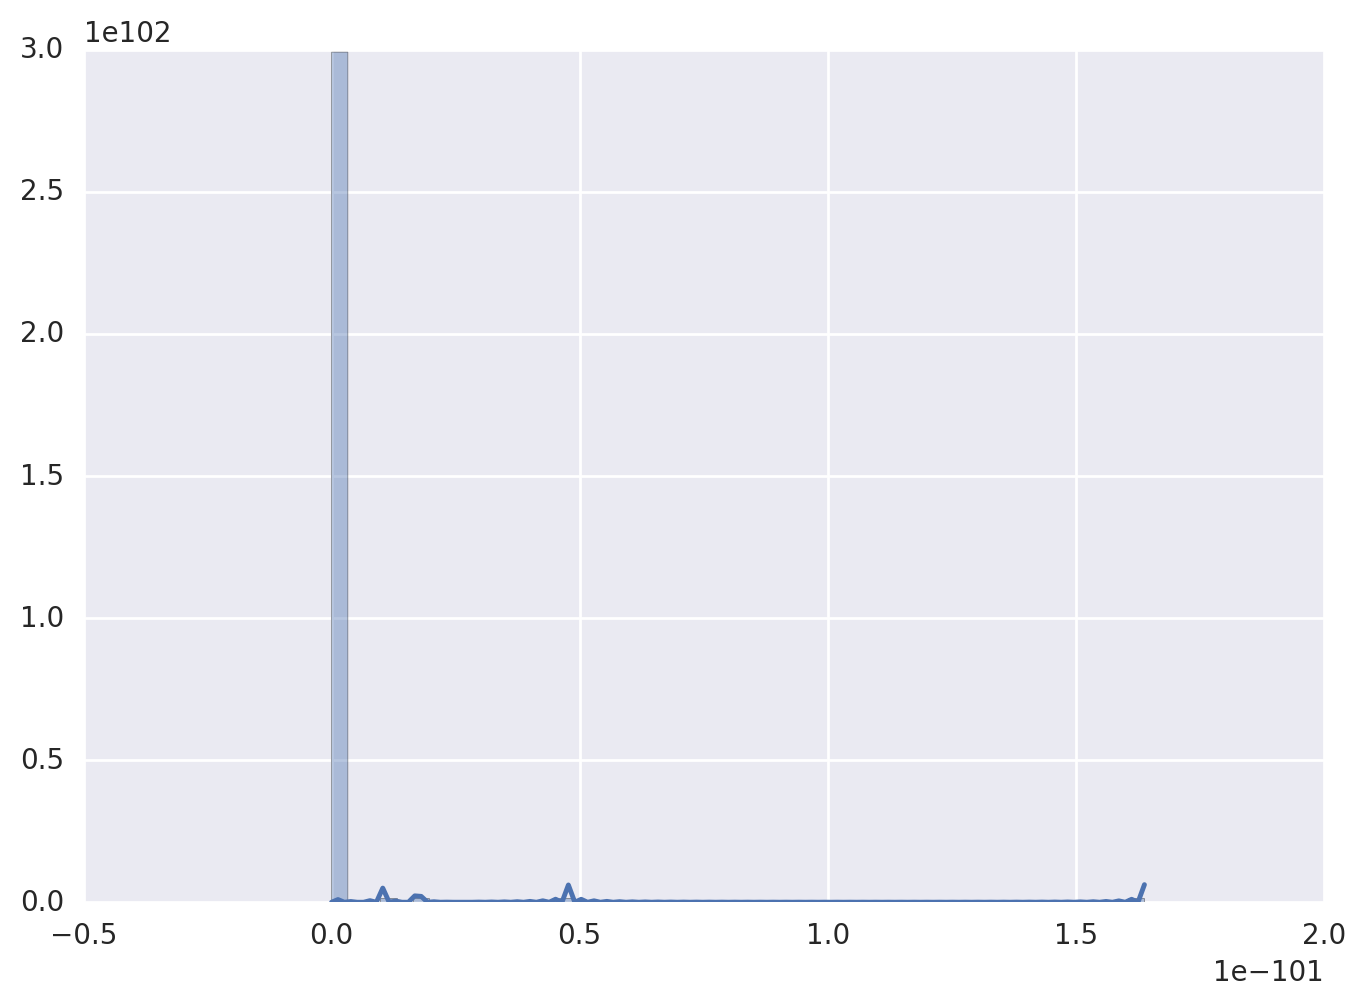

In [444]:
sns.distplot([x for x in kruskal_frame.values.flatten() if x < 1e-100])

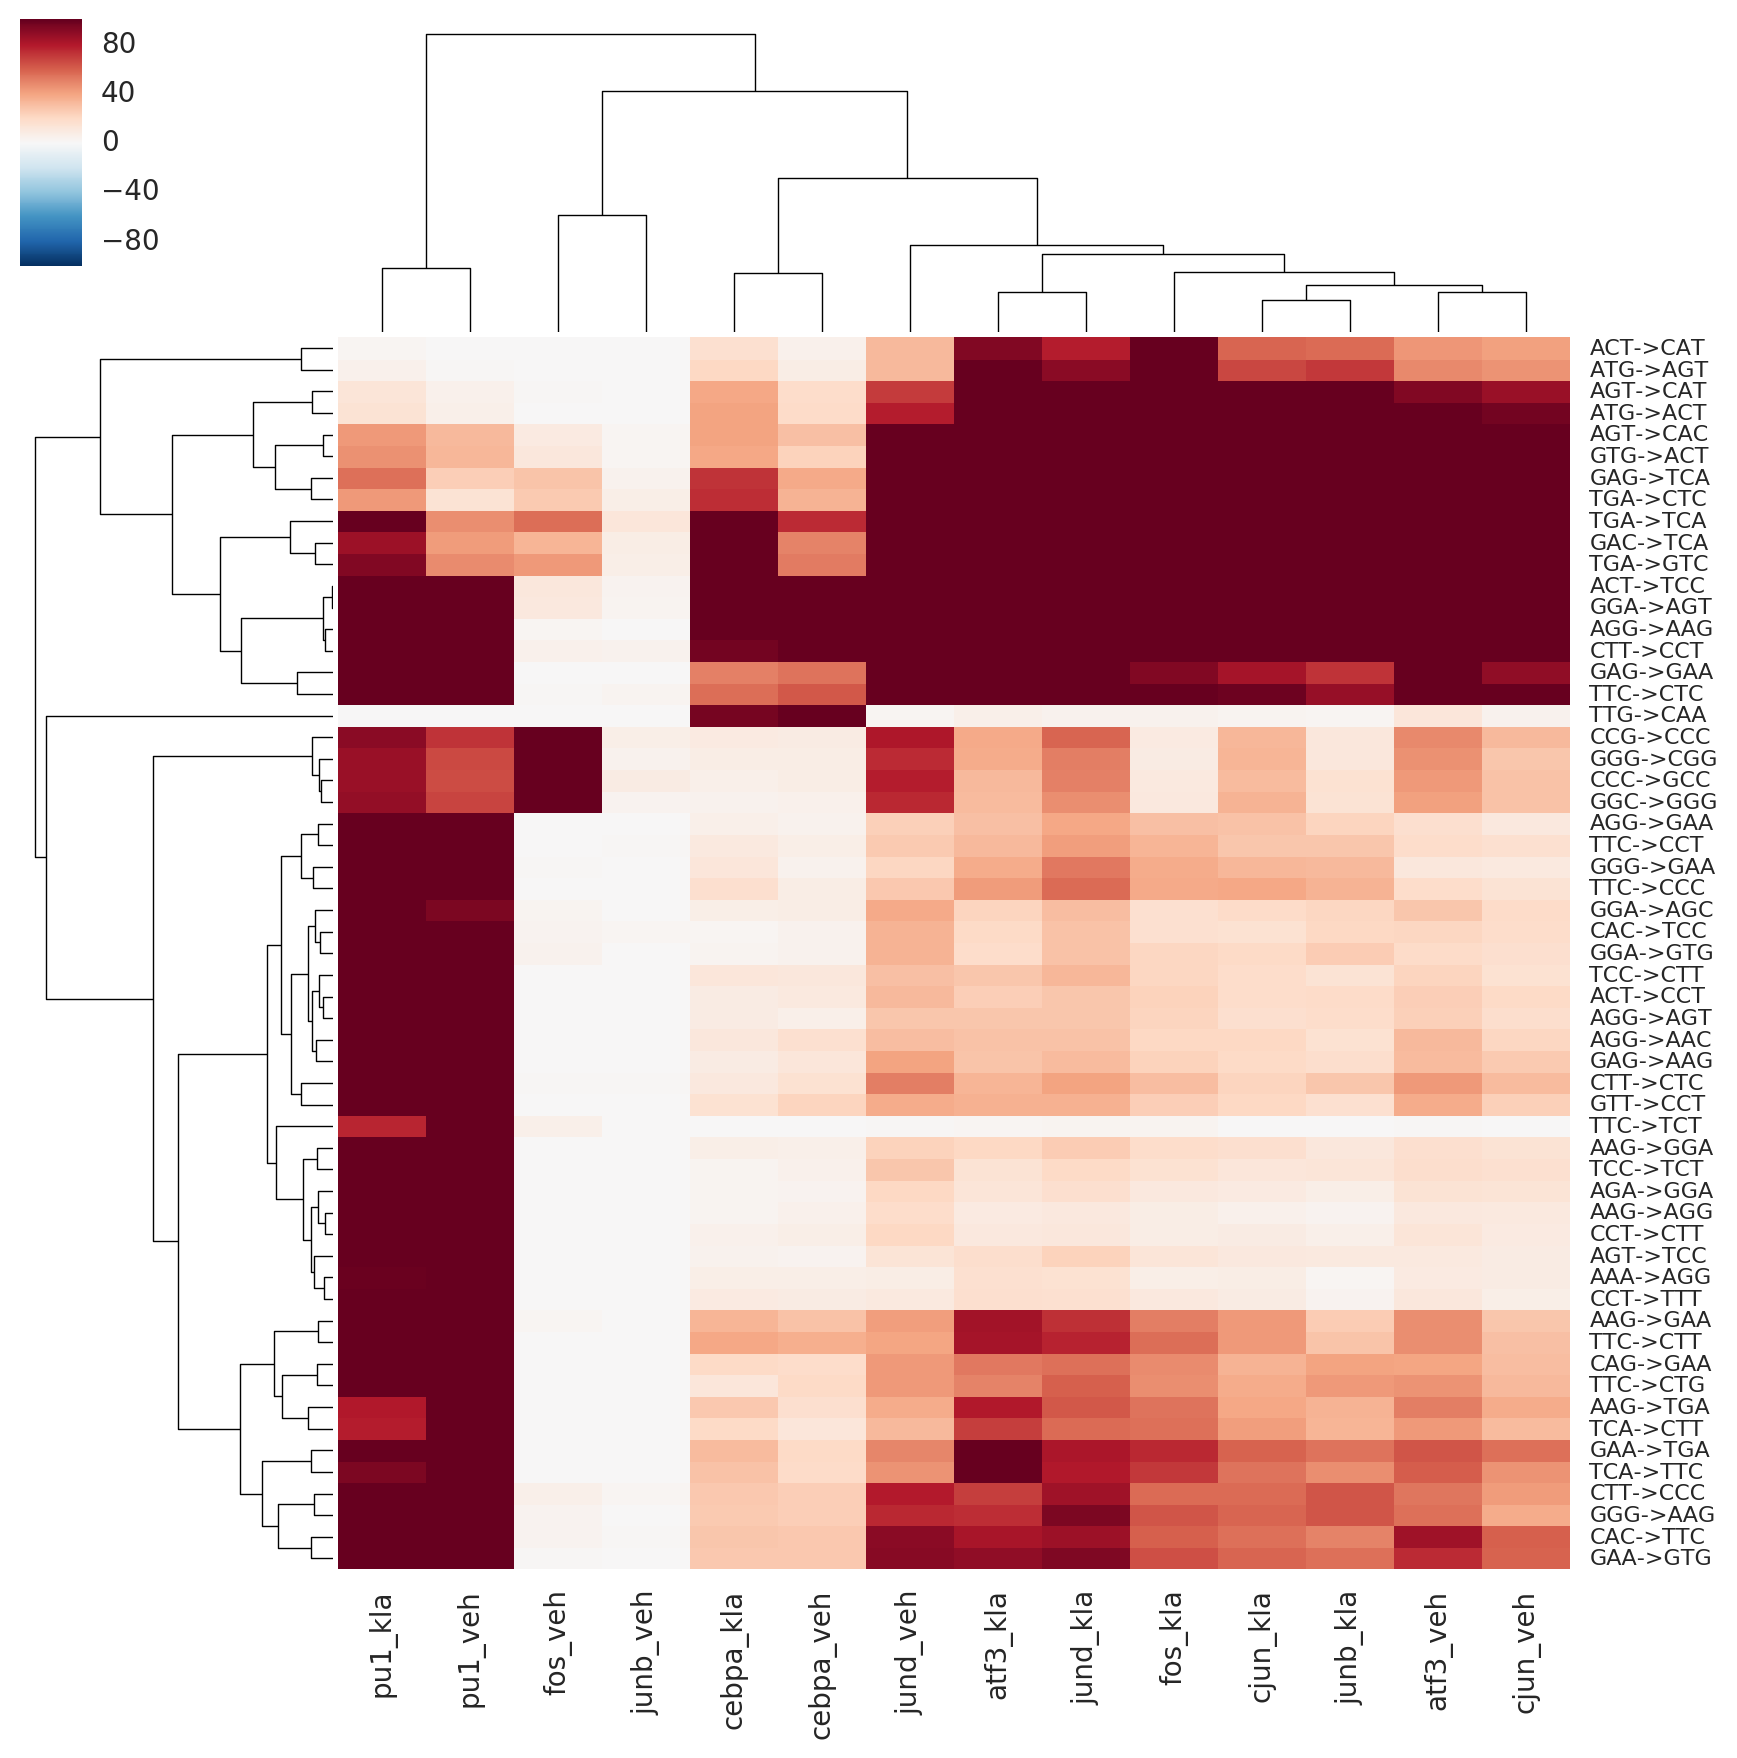

In [461]:
p_threshold = 1e-100
current_data = kruskal_frame[kruskal_frame.min(axis=1) < p_threshold]
cg = sns.clustermap(-1*np.log10(current_data + p_threshold),
               )
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=8, rotation=0, );

### Logistic Regression

In [130]:
# split data into training and test data
def get_split(features, labels, test_size):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    '''
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
       
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

In [12]:
# for monomers using all motifs
numIterations = 1
test_size = 0.5
strain = 'c57bl6'
factor_coeff_dict = {}
for treatment in ['veh', 'kla']:
    for monomer in ['atf3', 'cjun', 'fos', 'junb', 'jund', 'pu1', 'cebpa']:
        start = time.time()
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = background_ids    # select subset of background indices to use
                
        target_features = transition_frame[transition_frame.index.isin(target_indices)]
        background_features = transition_frame[transition_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        transition_features = pd.concat([target_features, background_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = transition_features.index.values)
        all_aucs = []
        all_coefficients = []
        all_precisions = []
        for i in range(numIterations):

            # split data into training and test sets
            training_transition_features, test_transition_features, training_labels, test_labels = get_split(
                transition_features, labels, test_size = test_size)
            #  Train affinity classifier
            transition_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            transition_classifier.fit(training_transition_features, training_labels)

            probas = transition_classifier.predict_proba(test_transition_features)
            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)
            current_coefficients = transition_classifier.coef_.flatten()
            all_coefficients.append(current_coefficients)
            
        end = time.time()
        mean_coefficients = np.mean(all_coefficients, axis=0)
        factor_coeff_dict[monomer + '_' + treatment] = mean_coefficients
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_aucs), np.var(all_aucs),
              'precision:', np.mean(all_precisions), np.var(all_precisions),  
              'numTestPositives:', np.sum(test_labels),
              end-start
             )
        

NameError: name 'background_ids' is not defined

In [13]:
# coefficients_frame = pd.DataFrame(factor_coeff_dict)
# coefficients_frame.index = transition_frame.columns.values
# for col in coefficients_frame.columns.values:
#     sns.distplot(coefficients_frame[col].values, label=col, hist_kws={'alpha':0.2})

# plt.legend()

# # transform_coffcients into z-scores
# coefficients_zscore_frame = coefficients_frame[[]]
# for col in coefficients_frame:
#     coefficients_zscore_frame[col] = scipy.stats.mstats.zscore(coefficients_frame[col].values)

# coefficients_zscore_frame.index = coefficients_frame.index.values
# coefficients_zscore_frame.columns = coefficients_frame.columns.values

### plot coefficents for vehicle
weight_threshold = 5

for treatment in ['veh']:
    data = coefficients_zscore_frame
    data = data[[x for x in coefficients_zscore_frame.columns.values if treatment in x]]
    data = data[(data.max(axis=1) >= weight_threshold) |
                (data.min(axis=1) < -1 * weight_threshold)
                ]
    cg = sns.clustermap(data,
                       vmax=weight_threshold,
                       vmin=-1*weight_threshold,
                       center = 0.0,
                       xticklabels=[x.replace('c57bl6_','') for x in data.columns.values])
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0, );

NameError: name 'coefficients_zscore_frame' is not defined

## grid search for optimal parameters

### Generate Order Maps

#### k=3

In [ ]:
if not os.path.isdir('./orderMaps/'):
    os.mkdir('./orderMaps/')
current_background_sequence_dict = {x:background_sequence_dict[x] for x in list(background_sequence_dict.keys())[:len(target_sequence_dict)]}

pool = multiprocessing.Pool(processes=28)
for current_interaction_distance in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 100, 200]:
    for current_window_overlap in [0, 1, 2]:
        pool.apply_async(
        calculate_kmerOrderMap,args=(target_sequence_dict,
                                   3, 
                                   current_window_overlap,
                                   current_interaction_distance,
                                   False,
                                   True,
                                   './orderMaps/target_interaction'+str(current_interaction_distance) + '_overlap'+str(current_window_overlap)
                                   )
                               )
                        

        pool.apply_async(
        calculate_kmerOrderMap,args = ( current_background_sequence_dict, 
                                        3, 
                                        current_window_overlap,
                                        current_interaction_distance,
                                        False,
                                        True,
                                        './orderMaps/background_interaction'+str(current_interaction_distance) + '_overlap'+str(current_window_overlap)
                                        )
                        )
pool.close()
pool.join()

#### k=2

In [ ]:
if not os.path.isdir('./orderMaps_2mer/'):
    os.mkdir('./orderMaps_2mer/')
current_background_sequence_dict = {x:background_sequence_dict[x] for x in list(background_sequence_dict.keys())[:len(target_sequence_dict)]}

pool = multiprocessing.Pool(processes=28)
for current_interaction_distance in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 100, 200]:
    for current_window_overlap in [0, 1]:
        pool.apply_async(
        calculate_kmerOrderMap,args=(target_sequence_dict,
                                   2, 
                                   current_window_overlap,
                                   current_interaction_distance,
                                   False,
                                   True,
                                   './orderMaps_2mer/target_interaction'+str(current_interaction_distance) + '_overlap'+str(current_window_overlap)
                                   )
                               )
                        

        pool.apply_async(
        calculate_kmerOrderMap,args = ( current_background_sequence_dict, 
                                        2, 
                                        current_window_overlap,
                                        current_interaction_distance,
                                        False,
                                        True,
                                        './orderMaps_2mer/background_interaction'+str(current_interaction_distance) + '_overlap'+str(current_window_overlap)
                                        )
                        )
pool.close()
pool.join()

0 0
0 0
0 1
0 1
1 0
1 0
1 1
1 1
2 0
2 0
2 1
2 1
3 0
3 0
3 1
3 1
4 0
4 0
4 1
4 1
5 0
5 0
5 1
5 1
6 0
6 0
6 1
6 1
writing pickle file 0 0
7 0
writing pickle file 0 0
7 0
writing pickle file 1 0
writing pickle file 1 0
7 1
7 1
writing pickle file 2 0
writing pickle file 2 0
8 0
8 0
writing pickle file 3 0
writing pickle file 3 0
8 1
8 1
writing pickle file 4 0
writing pickle file 4 0
9 0
9 0
writing pickle file 5 0
writing pickle file 5 0
9 1
9 1
writing pickle file 6 0
10 0
writing pickle file 6 0
10 0
writing pickle file 7 0
10 1
writing pickle file 7 0
10 1
writing pickle file 8 0
writing pickle file 8 0
20 0
20 0
writing pickle file 9 0
20 1
writing pickle file 9 0
20 1
writing pickle file 10 0
30 0
writing pickle file 10 0
30 0


### KS Tests

### Logistic Regression

In [14]:
k = 3
numIterations = 1
test_size = 0.5
strain = 'c57bl6'
        
kmer_index_dict = {}
counter = 0
for kmer in itertools.product(['A', 'C', 'G', 'T'], repeat=k):
    kmer_string = ''.join(kmer)
    kmer_index_dict[kmer_string] = counter
    counter += 1
    
index_kmer_dict = {kmer_index_dict[x]:x for x in kmer_index_dict}

flatIndex_transition_dict = {}
transition_flatIndex_dict = {}
counter = 0
for i in range(len(kmer_index_dict)):
    for j in range(len(kmer_index_dict)):
        kmer1 = index_kmer_dict[i]
        kmer2 = index_kmer_dict[j]
        flatIndex_transition_dict[counter] = kmer1 + '->' + kmer2
        transition_flatIndex_dict[kmer1 + '->' + kmer2] = counter
        counter += 1

In [ ]:
factor_list = []
treatment_list = []
roc_list = []
precision_list = []
distance_list = []
overlap_list = []

current_target_ids = sorted(target_sequence_dict.keys())
current_background_sequence_dict = {x:background_sequence_dict[x] for x in list(background_sequence_dict.keys())[:len(target_sequence_dict)]}
current_background_ids = sorted(current_background_sequence_dict.keys())
for current_interaction_distance in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 100, 200]:
    for current_window_overlap in [0, 1, 2]:
        start = time.time()
        print('*** reading features... interaction distance:', current_interaction_distance, 
              'overlap:', current_window_overlap,'***')
        
        ### read in features ###
        target_orderMap_path = './orderMaps/target_interaction'+str(current_interaction_distance) + '_overlap'+str(current_window_overlap) + '_orderMaps.pickle'
        background_orderMap_path = './orderMaps/background_interaction'+str(current_interaction_distance) + '_overlap'+str(current_window_overlap) + '_orderMaps.pickle'
        
#         current_target_ids_path = './orderMaps/target_interaction'+str(current_interaction_distance) + '_overlap'+str(current_window_overlap) + '_ids.pickle'
#         current_background_ids_path = './orderMaps/background_interaction'+str(current_interaction_distance) + '_overlap'+str(current_window_overlap) + '_ids.pickle'
#         current_current_target_ids = pickle.load(open(current_target_ids_path, 'rb'))
#         current_current_background_ids = pickle.load(open(current_background_ids_path, 'rb'))
        
        current_target_order_maps = pickle.load(open(target_orderMap_path, 'rb'))
        current_background_order_maps = pickle.load(open(background_orderMap_path, 'rb'))
        
        flattened_dict = {}
        for i in range(len(current_target_order_maps)):
            current_id = current_target_ids[i]
            flattened_dict[current_id] = current_target_order_maps[i].flatten()
        for i in range(len(current_background_order_maps)):
            current_id = current_background_ids[i]
            flattened_dict[current_id] = current_background_order_maps[i].flatten()

        current_transition_frame = pd.DataFrame(flattened_dict).T
        current_transition_frame.columns = [flatIndex_transition_dict[x] for x in current_transition_frame.columns.values]
        end = time.time()
        print('time to read data:', end-start)
        ### run classifier for each monomer in each treatment ###
        for treatment in ['veh', 'kla']:
            for monomer in ['atf3', 'cjun', 'fos', 'junb', 'jund', 'pu1', 'cebpa']:
                start = time.time()
                target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
                background_indices = current_background_ids    # select subset of background indices to use

                target_features = current_transition_frame[current_transition_frame.index.isin(target_indices)]
                background_features = current_transition_frame[current_transition_frame.index.isin(background_indices)]

                # merge target and background features together 
                transition_features = pd.concat([target_features, background_features])
                labels = pd.Series([True if x in target_indices else False for x in transition_features.index.values],
                                   index = transition_features.index.values)
                all_aucs = []
                all_coefficients = []
                all_precisions = []
                for i in range(numIterations):

                    # split data into training and test sets
                    training_transition_features, test_transition_features, training_labels, test_labels = get_split(
                        transition_features, labels, test_size = test_size)
                    #  Train affinity classifier
                    transition_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
                    transition_classifier.fit(training_transition_features, training_labels)

                    probas = transition_classifier.predict_proba(test_transition_features)
                    # score predictions
                    current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
                    current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

                    all_aucs.append(current_roc_auc)
                    all_precisions.append(current_precision)
                    current_coefficients = transition_classifier.coef_.flatten()
                    all_coefficients.append(current_coefficients)

                end = time.time()
                mean_coefficients = np.mean(all_coefficients, axis=0)
                
                roc_list.append(np.mean(all_aucs))
                factor_list.append(monomer)
                treatment_list.append(treatment)
                precision_list.append(np.mean(all_precisions))
                distance_list.append(current_interaction_distance)
                overlap_list.append(current_window_overlap)
                print(monomer + '_' + treatment,
                      'roc:', np.mean(all_aucs), 
                      'precision:', np.mean(all_precisions),  
                      'positive:', np.sum(labels),
                      'negative:',len(labels) - np.sum(labels),
                      'runTime:', end-start
                     )


*** reading features... interaction distance: 0 overlap: 0 ***
time to read data: 13.664220571517944


In [ ]:
performance_frame = pd.DataFrame({'Factor':factor_list,
                                 'Treatment': treatment_list,
                                 'aucROC':roc_list,
                                 'aucPR':precision_list,
                                 'Interaction Distance': distance_list,
                                 'Overlap': overlap_list})

pickle.dump(performance_frame, open('./performance_frame.pickle', 'wb'))

In [ ]:
performance_frame = pd.read_pickle('./performance_frame.pickle')

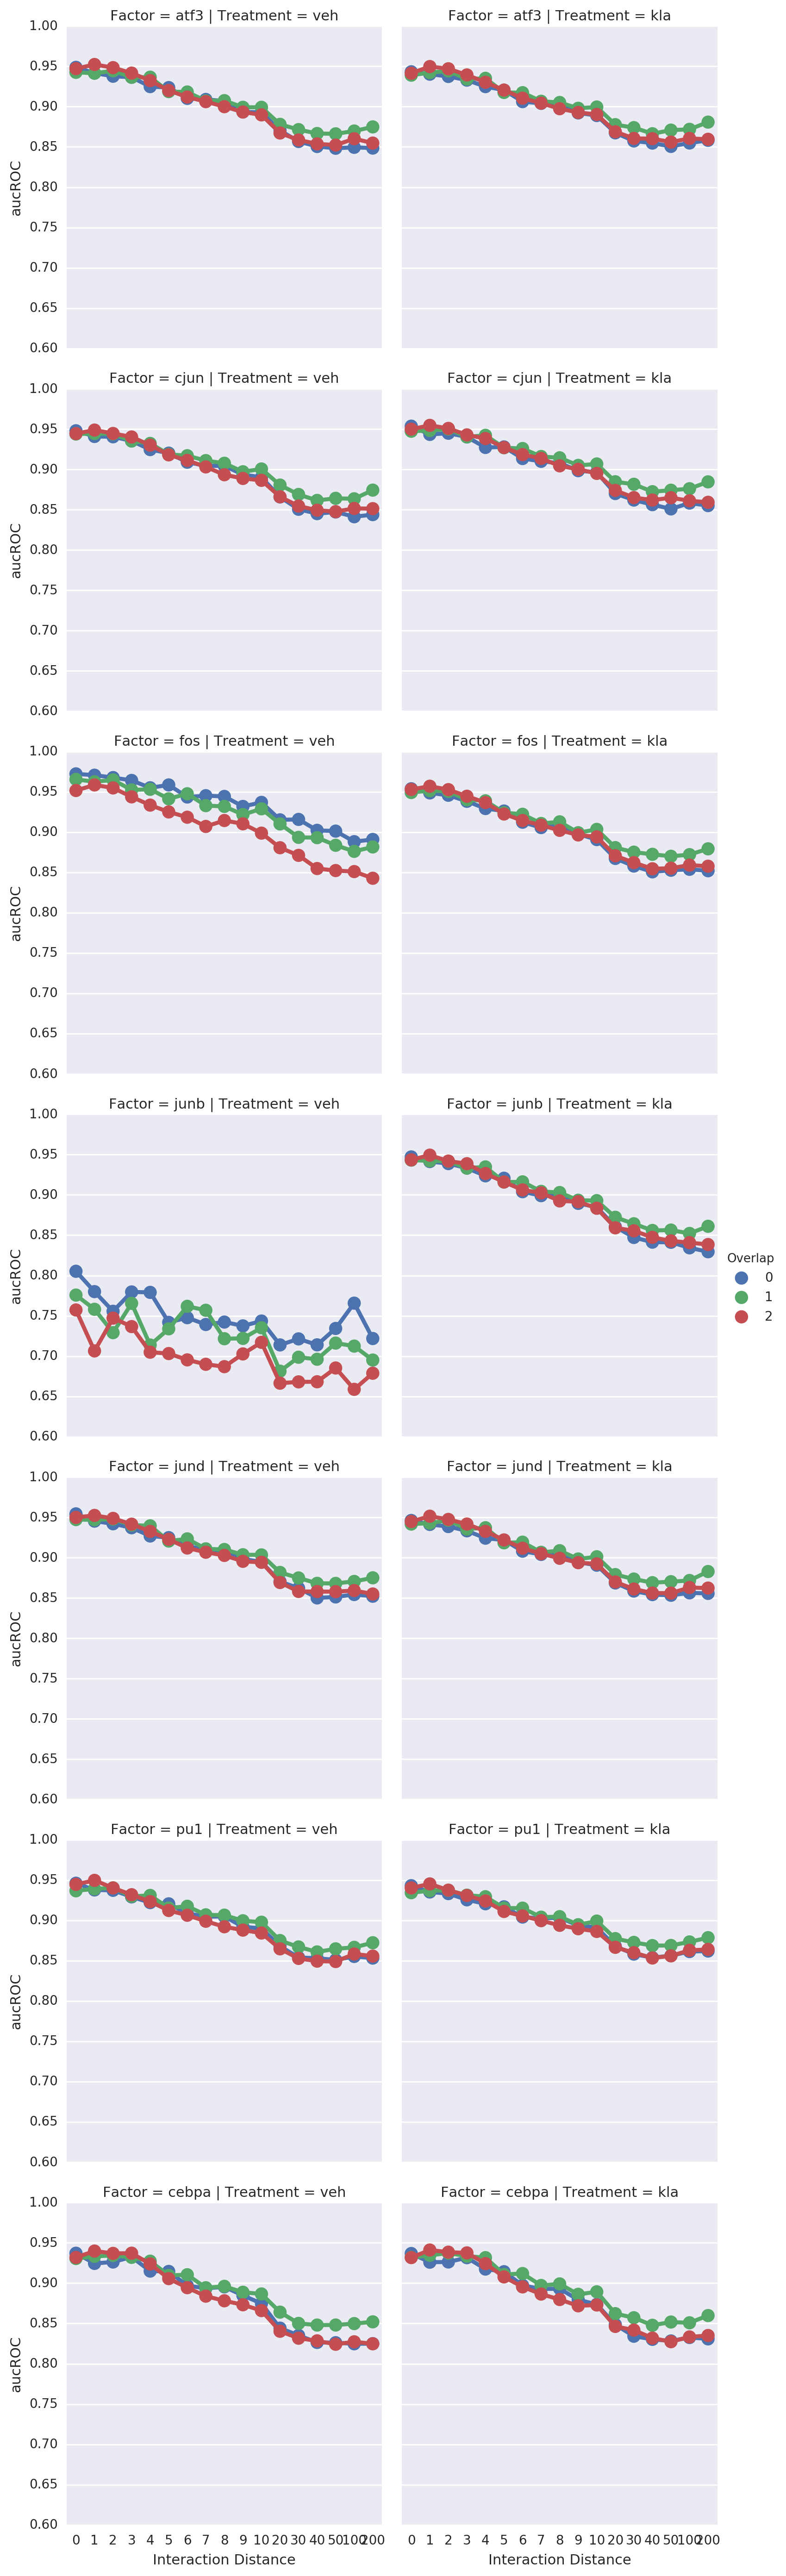

In [20]:
sns.factorplot(data = performance_frame,
               x='Interaction Distance',
               y='aucROC',
               hue = 'Overlap',
               row='Factor',
               col = 'Treatment')

In [27]:
performance_frame['aucPR'] = [np.mean(x) for x in performance_frame['aucPR']]

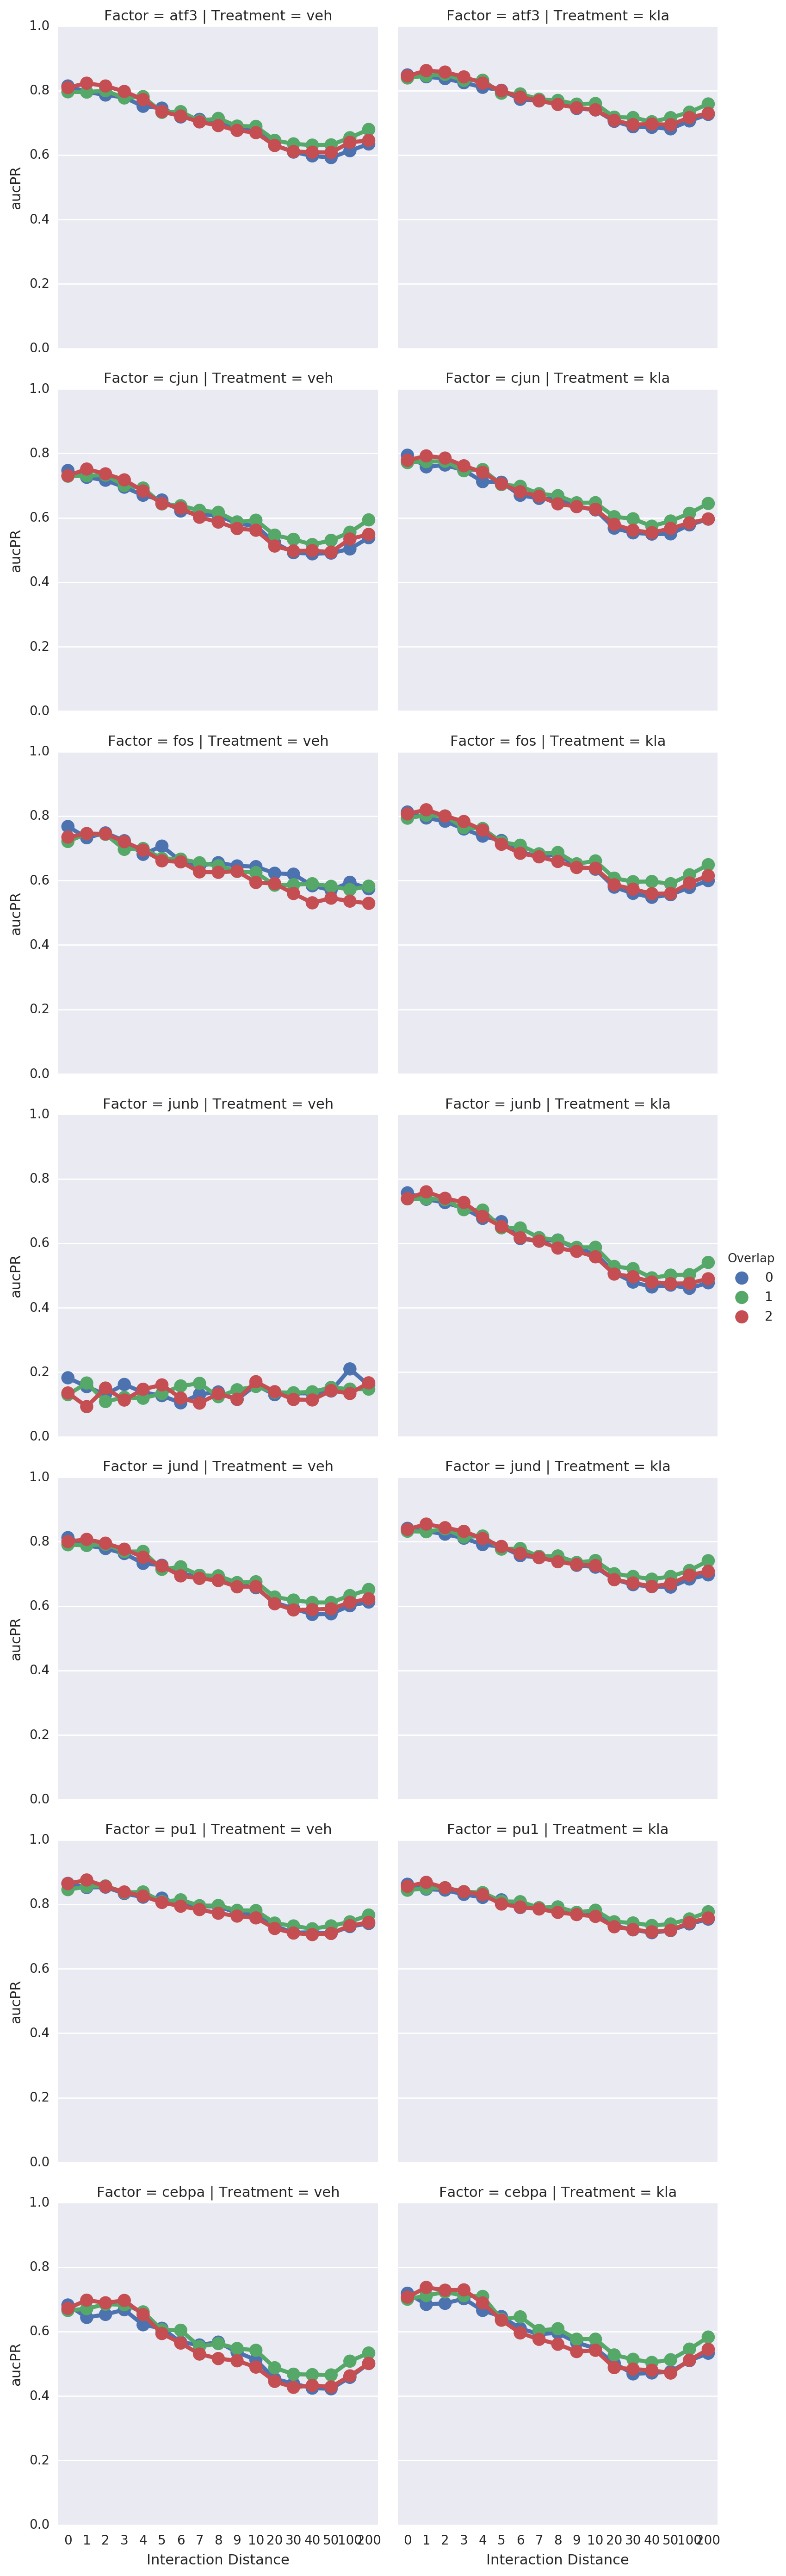

In [29]:
sns.factorplot(data = performance_frame,
               x='Interaction Distance',
               y='aucPR',
               hue = 'Overlap',
               row='Factor',
               col = 'Treatment')

### 1x background

In [ ]:
factor_list = []
treatment_list = []
roc_list = []
precision_list = []
distance_list = []
overlap_list = []

current_target_ids = sorted(target_sequence_dict.keys())
current_background_sequence_dict = {x:background_sequence_dict[x] for x in list(background_sequence_dict.keys())[:len(target_sequence_dict)]}
current_background_ids = sorted(current_background_sequence_dict.keys())
for current_interaction_distance in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    for current_window_overlap in [0, 1, 2]:
        start = time.time()
        print('*** reading features... interaction distance:', current_interaction_distance, 
              'overlap:', current_window_overlap,'***')
        
        ### read in features ###
        target_orderMap_path = './orderMaps/target_interaction'+str(current_interaction_distance) + '_overlap'+str(current_window_overlap) + '_orderMaps.pickle'
        background_orderMap_path = './orderMaps/background_interaction'+str(current_interaction_distance) + '_overlap'+str(current_window_overlap) + '_orderMaps.pickle'
        
#         current_target_ids_path = './orderMaps/target_interaction'+str(current_interaction_distance) + '_overlap'+str(current_window_overlap) + '_ids.pickle'
#         current_background_ids_path = './orderMaps/background_interaction'+str(current_interaction_distance) + '_overlap'+str(current_window_overlap) + '_ids.pickle'
#         current_current_target_ids = pickle.load(open(current_target_ids_path, 'rb'))
#         current_current_background_ids = pickle.load(open(current_background_ids_path, 'rb'))
        
        current_target_order_maps = pickle.load(open(target_orderMap_path, 'rb'))
        current_background_order_maps = pickle.load(open(background_orderMap_path, 'rb'))
        
        flattened_dict = {}
        for i in range(len(current_target_order_maps)):
            current_id = current_target_ids[i]
            flattened_dict[current_id] = current_target_order_maps[i].flatten()
        for i in range(len(current_background_order_maps)):
            current_id = current_background_ids[i]
            flattened_dict[current_id] = current_background_order_maps[i].flatten()

        current_transition_frame = pd.DataFrame(flattened_dict).T
        current_transition_frame.columns = [flatIndex_transition_dict[x] for x in current_transition_frame.columns.values]
        end = time.time()
        print('time to read data:', end-start)
        ### run classifier for each monomer in each treatment ###
        for treatment in ['veh', 'kla']:
            for monomer in ['atf3', 'cjun', 'fos', 'junb', 'jund', 'pu1', 'cebpa']:
                start = time.time()
                target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
                background_indices = current_background_ids    # select subset of background indices to use

                target_features = current_transition_frame[current_transition_frame.index.isin(target_indices)]
                background_features = current_transition_frame[current_transition_frame.index.isin(background_indices)]
                background_features = background_features.ix[:len(target_indices),:]

                # merge target and background features together 
                transition_features = pd.concat([target_features, background_features])
                labels = pd.Series([True if x in target_indices else False for x in transition_features.index.values],
                                   index = transition_features.index.values)
                all_aucs = []
                all_coefficients = []
                all_precisions = []
                for i in range(numIterations):

                    # split data into training and test sets
                    training_transition_features, test_transition_features, training_labels, test_labels = get_split(
                        transition_features, labels, test_size = test_size)
                    #  Train affinity classifier
                    transition_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
                    transition_classifier.fit(training_transition_features, training_labels)

                    probas = transition_classifier.predict_proba(test_transition_features)
                    # score predictions
                    current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas[:, 1], average = None)
                    current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

                    all_aucs.append(current_roc_auc)
                    all_precisions.append(current_precision)
                    current_coefficients = transition_classifier.coef_.flatten()
                    all_coefficients.append(current_coefficients)

                end = time.time()
                mean_coefficients = np.mean(all_coefficients, axis=0)
                
                roc_list.append(np.mean(all_aucs))
                factor_list.append(monomer)
                treatment_list.append(treatment)
                precision_list.append(np.mean(all_precisions))
                distance_list.append(current_interaction_distance)
                overlap_list.append(current_window_overlap)
                print(monomer + '_' + treatment,
                      'roc:', np.mean(all_aucs), 
                      'precision:', np.mean(all_precisions),  
                      'target:', np.sum(labels),
                      'background:',background_features.shape[0],
                      'runTime:', end-start
                     )



*** reading features... interaction distance: 0 overlap: 0 ***
time to read data: 14.06832218170166
atf3_veh roc: 0.936031605202 precision: 0.932370627065 target: 22154 background: 22154 runTime: 30.926641941070557
cjun_veh roc: 0.930535667067 precision: 0.927926568335 target: 12731 background: 12731 runTime: 12.391704559326172
fos_veh roc: 0.965202 precision: 0.969015410197 target: 1999 background: 1999 runTime: 1.6707613468170166
junb_veh roc: 0.757869406868 precision: 0.756864804755 target: 496 background: 496 runTime: 1.320143699645996
jund_veh roc: 0.936251901434 precision: 0.933192369885 target: 18150 background: 18150 runTime: 26.082855939865112
pu1_veh roc: 0.941291575055 precision: 0.936304207793 target: 40158 background: 40158 runTime: 95.31574749946594
cebpa_veh roc: 0.911390096415 precision: 0.906080560816 target: 11755 background: 11755 runTime: 10.492919206619263
atf3_kla roc: 0.937119795068 precision: 0.932525698481 target: 34877 background: 34877 runTime: 72.27815771102

In [ ]:
performance_1x_frame = pd.DataFrame({'Factor':factor_list,
                                 'Treatment': treatment_list,
                                 'aucROC':roc_list,
                                 'aucPR':precision_list,
                                 'Interaction Distance': distance_list,
                                 'Overlap': overlap_list})

pickle.dump(performance_1x_frame, open('./performance_1x_frame.pickle', 'wb'))

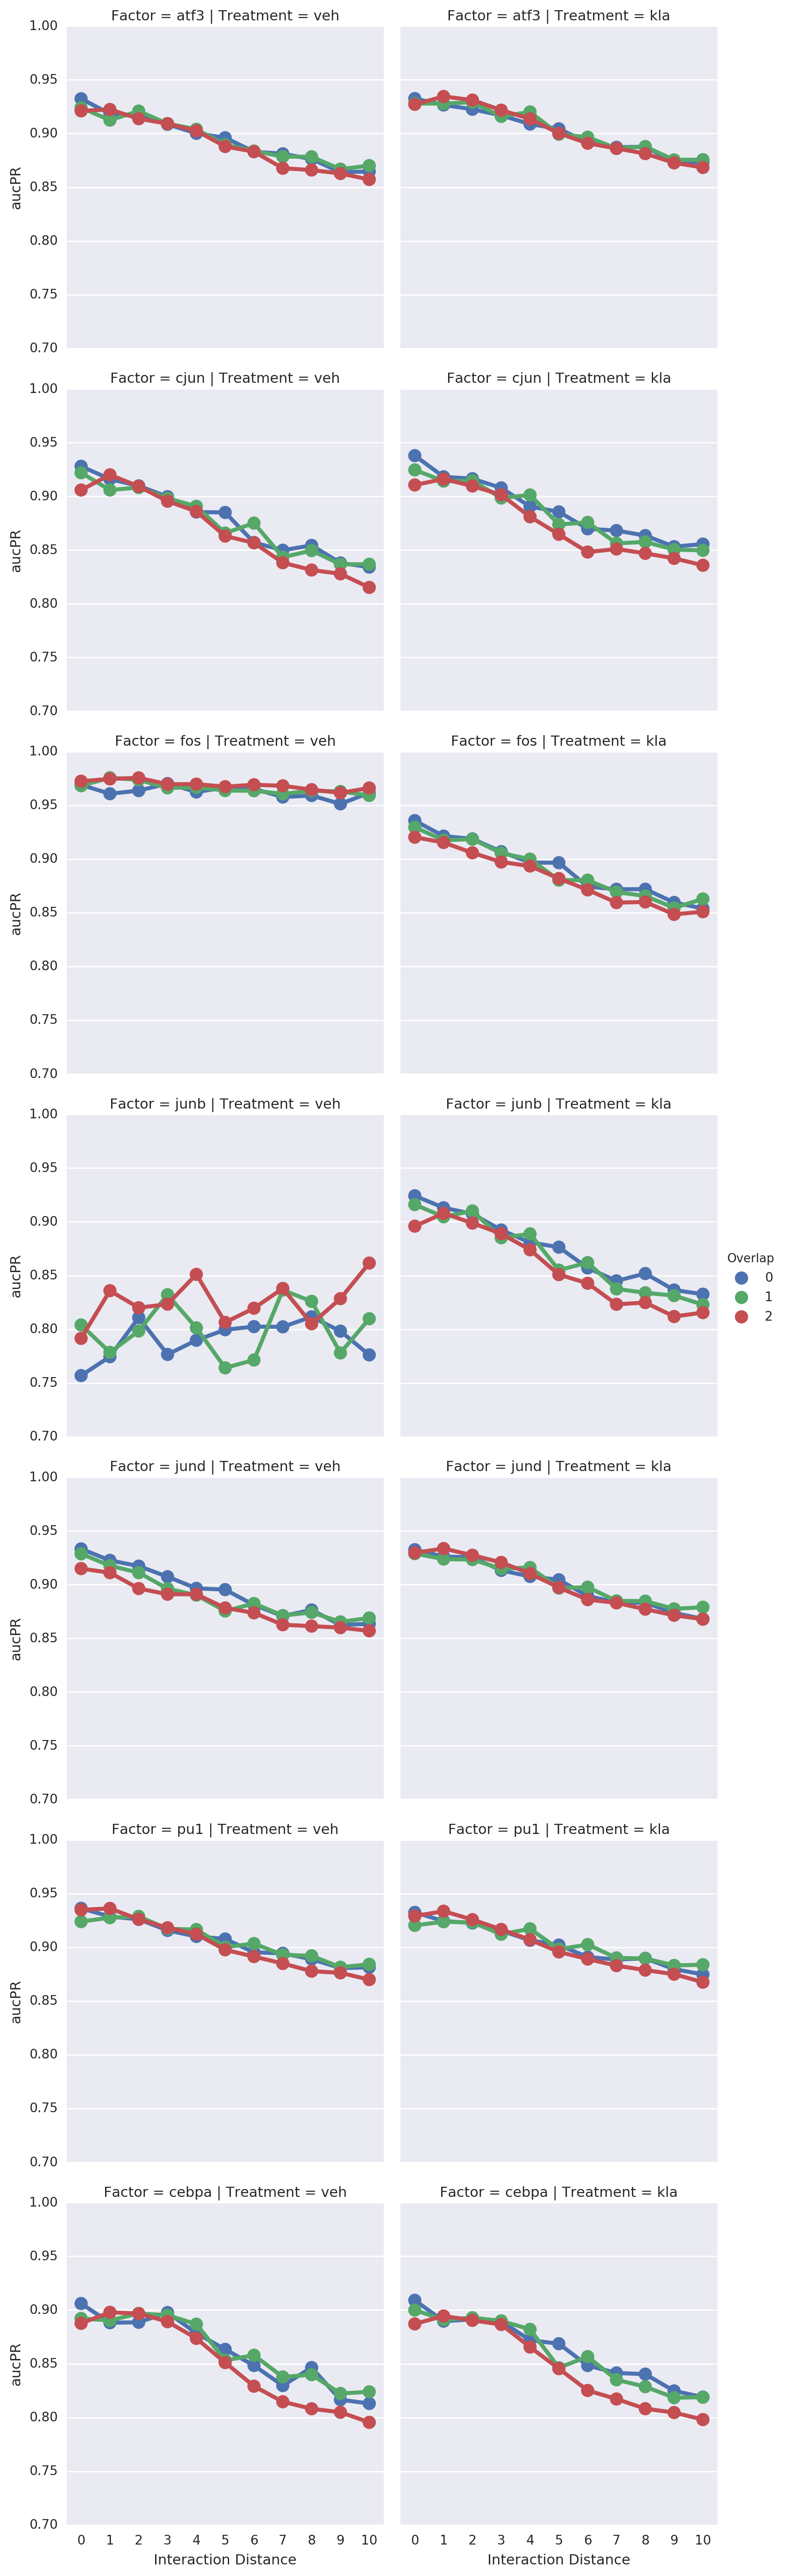

In [49]:
sns.factorplot(data = performance_1x_frame,
               x='Interaction Distance',
               y='aucPR',
               hue = 'Overlap',
               row='Factor',
               col = 'Treatment')

# Ensemble Model using k-mer pairs

In [3]:
def calculate_kmer_interaction_matrix(id_sequence_dict, 
                                      k, 
                                      interaction_distances,
                                      verbose=False,
                                      create_pickle = False,
                                      pickle_prefix = None):
    '''
    Reads in a dictionary with id_sequence_dict and calculates a
    numSequences X interaction_distance X interaction_matrix
    '''
    ids = sorted(id_sequence_dict.keys())
    sequences = [id_sequence_dict[x] for x in ids]
#     print(interaction_distances)
    # initialize kmer indices
    kmer_pair_index_dict = {}
    counter = 0
    kmers = [''.join(x) for x in itertools.product(['A', 'C', 'G', 'T'], repeat=k)]
    kmer_pairs = []
    for i in range(len(kmers)):
        for j in range(len(kmers)):
            kmer_string = '-'.join([kmers[i], kmers[j]])
            kmer_pair_index_dict[kmer_string] = counter
            kmer_pairs.append(kmer_string)
            counter += 1
    # loop through different interaction distances
    interactionMatrixList_dict = {} # {interactionDistance, list of interaction matrices}
    lock = threading.Lock()
    thread_list = []
    for interaction_distance in interaction_distances:
        try:
            current_thread = threading.Thread(target = count_interactions,
                                              args = (sequences,
                                                      kmer_pair_index_dict,
                                                      interaction_distance,
                                                      verbose,
                                                      lock,
                                                      interactionMatrixList_dict)
                                             )
            thread_list.append(current_thread)
            current_thread.start()
        finally:
            if lock.locked_lock():
                lock.release()
    for current_thread in thread_list:
        current_thread.join()
    interactionMatrix_frame_dict = {}
    for distance in interactionMatrixList_dict.keys():
        frame = pd.DataFrame(interactionMatrixList_dict[distance], index = ids, columns=kmer_pairs)
        interactionMatrix_frame_dict[distance] = frame
    if create_pickle:
        if pickle_prefix == None:
            pickle_prefix = './'
        print('writing pickle file')
        pickle.dump(interactionMatrix_frame_dict, open(pickle_prefix + 'interactionMatrix_frame_dict.pickle', 'wb'))
    return interactionMatrix_frame_dict, kmer_pair_index_dict
    

In [4]:
def count_interactions(sequences,
                       kmer_pair_index_dict,
                       interaction_distance,
                       verbose,
                       thread_lock,
                       interactionMatrixList_dict
                       ):
    '''
    create a list of matrices of k-mer pairs
    '''
    # extract length of k-mers
    k = len(list(kmer_pair_index_dict.keys())[0].split('-')[0])
    
    # create list to hold results
    interactionMatrix_list = []
    for seq in sequences:
        # initialize matrix for sequence
        num_kmers = len(kmer_pair_index_dict)
        interaction_matrix = np.zeros(num_kmers, dtype=np.int16)
        
       
        scan_start = 0
        # leave room for last interacting kmer
        seq_length = len(seq)
        scan_end = seq_length - (2*k + interaction_distance) + 1
                
        for i in range(scan_start, scan_end):
            start_1 = i
            end_1 = start_1 + k
            
            start_2 = end_1 + interaction_distance
            end_2 = start_2 + k
            
            # calculate kmer
            kmer_1 = seq[start_1: end_1]
            kmer_2 = seq[start_2: end_2]
            
            # get kmer indices
            if not 'N' in kmer_1 and not 'N' in kmer_2:
                index = kmer_pair_index_dict[kmer_1 + '-' + kmer_2]
                # update matrix
                interaction_matrix[index] +=1
#             print(start_1, end_1, start_2, end_2, kmer_1, kmer_2)
        interactionMatrix_list.append(interaction_matrix)
        
    while thread_lock.locked_lock():
        time.sleep(1)
    thread_lock.acquire()
    interactionMatrixList_dict[interaction_distance] = np.array(interactionMatrix_list)



### Timing Tests with interaction matrices

In [12]:
numseq_list = []
numproc_list = []
time_list = []
for numSequences in [1, 10, 100, 1000,10000]:
    peak_indices = summary_frame[summary_frame['c57bl6_atf3_veh'] > 0.0].index.values[:numSequences]
    peak_sequences = [target_sequence_dict[x] for x in peak_indices]
    background_indices = list(background_sequence_dict.keys())[:len(peak_indices)]
    background_sequences = [background_sequence_dict[x][:numSequences] for x in background_indices]

    test_dict = dict(zip(np.concatenate([peak_indices, background_indices]),
                    np.concatenate([peak_sequences, background_sequences])))
    start = time.time()

    interactionMatrix_frame, k_mer_index_dict = calculate_kmer_interaction_matrix(test_dict, 
                                      3, 
                                      [0,1,2,3,4,5,10,50,100],
                                      verbose=False,
                                      create_pickle = False,
                                      pickle_prefix = None)
    end = time.time()
    numseq_list.append(numSequences)
    time_list.append(end-start)
    print(end-start, numSequences)

6.060799837112427 1
3.1529409885406494 10
0.6845641136169434 100
13.413875579833984 1000
86.16002655029297 10000


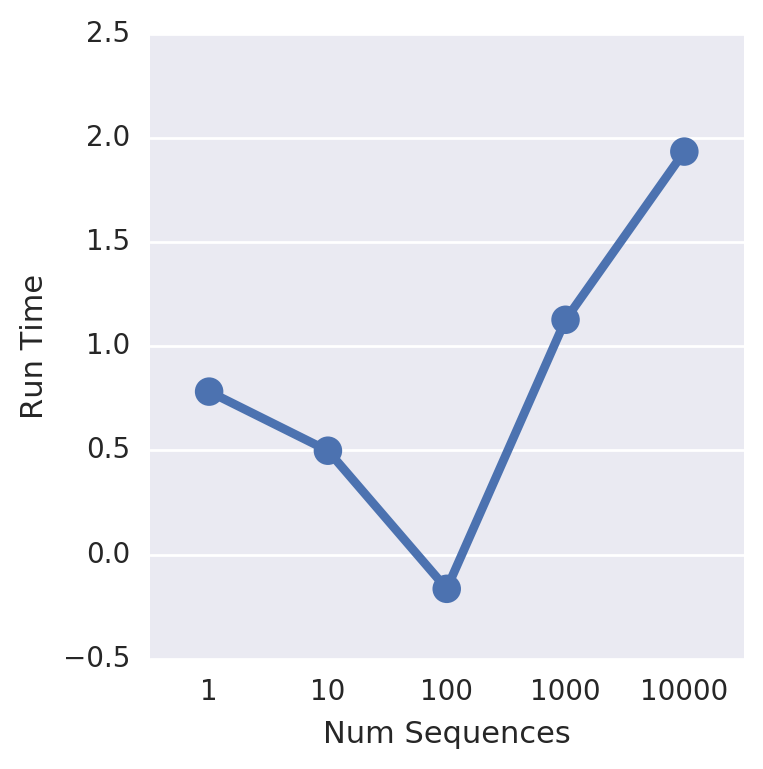

In [13]:
time_frame = pd.DataFrame({'Run Time': np.log10(np.array(time_list)),
                           'Num Sequences': numseq_list})
sns.factorplot(data = time_frame,
               x = 'Num Sequences',
               y = 'Run Time',
              )


In [14]:
objects =  [(var, sys.getsizeof(obj)/1000000000) for var, obj in locals().items()]

objects.sort(key=lambda x:x[1], reverse = True)

print(objects[:10])

## Generate Features

In [ ]:
start = time.time()
if not os.path.isdir('./kmer_pair_matrices/'):
    os.mkdir('./kmer_pair_matrices/')
current_background_sequence_dict = {x:background_sequence_dict[x] for x in list(background_sequence_dict.keys())[:len(target_sequence_dict)]}

interactionMatrix_frame_dict, k_mer_index_dict = calculate_kmer_interaction_matrix(target_sequence_dict, 
                                      3, 
                                      range(100),
                                      verbose=False,
                                      create_pickle = True,
                                      pickle_prefix = './kmer_pair_matrices/target_')
end = time.time()
print(end-start)
interactionMatrix_background_frame_dict, k_mer_index_dict = calculate_kmer_interaction_matrix(current_background_sequence_dict, 
                                      3, 
                                      range(100),
                                      verbose=False,
                                      create_pickle = True,
                                      pickle_prefix = './kmer_pair_matrices/background_')
end = time.time()
print(end-start)

In [19]:
interactionMatrix_frame_dict = pd.read_pickle('./kmer_pair_matrices/target_interactionMatrix_frame_dict.pickle')
interactionMatrix_background_frame_dict = pd.read_pickle('./kmer_pair_matrices/background_interactionMatrix_frame_dict.pickle')

## Train Classifier

In [23]:
# split data into training and test data
def get_split(labels, test_size):
    '''
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    '''
    
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
       
    all_ids = true_ids + false_ids
    all_labels = labels[labels.index.isin(all_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(all_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(all_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [all_ids[i] for i in training_indices]
    test_ids = [all_ids[i] for i in test_indices]
    
    training_labels = all_labels[all_labels.index.isin(training_ids)]
    test_labels = all_labels[all_labels.index.isin(test_ids)]
    
    return training_labels, test_labels
    

In [35]:
test_size = 0.5
numIterations = 1

In [ ]:
factor_list = []
treatment_list = []
auc_list = []
auc_type = []


strain = 'c57bl6'
interaction_distances = range(100)
interaction_weights_dict = {}
combined_weights_dict = {}
for treatment in ['veh', 'kla']:
    for factor in ['atf3', 'cjun', 'fos', 'junb', 'jund', 'pu1', 'cebpa']:
        print(factor, treatment)
        start = time.time()
        target_indices = summary_frame[summary_frame[strain + '_' + factor + '_' + treatment] > 0.0].index.values
        background_indices = np.array(list(current_background_sequence_dict.keys()))    # select subset of background indices to use

        
        training_classifier_scores = []
        testing_classifier_scores = []
        labels = pd.Series([True] * len(target_indices) + [False] * len(background_indices),
                                   index = np.concatenate([target_indices, background_indices],axis=0))
        interaction_weights_dict[factor+ '_'+treatment] = {}
        for i in range(numIterations):
        # split data
            training_labels, test_labels = get_split(labels, test_size = test_size)

            for interaction_distance in interaction_distances:
                # merge target and background features together 
                target_features = interactionMatrix_frame_dict[interaction_distance].ix[target_indices,:]
                background_features = interactionMatrix_background_frame_dict[interaction_distance].ix[background_indices,:]

                features = pd.concat([target_features, background_features])
                # standardize features
    #             scaler = preprocessing.StandardScaler()
    #             standardized_features = pd.DataFrame(scaler.fit_transform(features))
    #             standardized_features.columns = features.columns.values
    #             standardized_features.index = features.index.values

    #             training_features = standardized_features.ix[training_labels.index.values]
    #             test_features = standardized_features.ix[test_labels.index.values]
                training_features = features.ix[training_labels.index.values]
                test_features = features.ix[test_labels.index.values]

                # Train classifier for current distance
                current_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
                current_classifier.fit(training_features, training_labels)

                # retrieve model coefficients
                current_coefficients = current_classifier.coef_.flatten()
                if not interaction_distance in interaction_weights_dict[factor+'_'+treatment]:
                    interaction_weights_dict[factor+'_'+treatment][interaction_distance] = []
                interaction_weights_dict[factor+'_'+treatment][interaction_distance].append(current_coefficients)
                
                # generate features for ensemble classifier
                current_training_scores = current_classifier.decision_function(training_features)
                current_testing_scores = current_classifier.decision_function(test_features)
                training_classifier_scores.append(current_training_scores)
                testing_classifier_scores.append(current_testing_scores)
                
                # score current_classifier
                current_probas = current_classifier.predict_proba(test_features)
                current_roc = sklearn.metrics.roc_auc_score(test_labels, current_probas[:, 1], average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, current_probas[:, 1], average = None)
                print(interaction_distance, current_roc, current_precision)

                factor_list.append(factor)
                treatment_list.append(treatment)
                auc_list.append(current_roc)
                auc_type.append(str(interaction_distance))

            # train combined classifier
            combined_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
            training_combined_features = pd.DataFrame(training_classifier_scores).T
            testing_combined_features = pd.DataFrame(testing_classifier_scores).T
            combined_classifier.fit(training_combined_features, training_labels)

            # retrieve combined classifier coefficients
            combined_coefficients = combined_classifier.coef_.flatten()
            if not factor+'_'+treatment in combined_weights_dict:
                combined_weights_dict[factor+'_'+treatment] = []
            combined_weights_dict[factor+'_'+treatment].append(combined_coefficients)
            
            # score combined classifier
            combined_probas = combined_classifier.predict_proba(testing_combined_features)
            combined_roc = sklearn.metrics.roc_auc_score(test_labels, combined_probas[:, 1], average = None)
            combined_precision = sklearn.metrics.average_precision_score(test_labels, combined_probas[:, 1], average = None)
        end = time.time()
        
        print(factor, treatment, combined_roc, combined_precision, end-start)
        factor_list.append(factor)
        treatment_list.append(treatment)
        auc_list.append(combined_roc)
        auc_type.append('combined')

In [49]:
pickle.dump(interaction_weights_dict, open('./interaction_weights_dict.pickle', 'wb'))

pickle.dump(combined_weights_dict, open('./combined_weights_dict.pickle', 'wb'))

In [4]:
interaction_weights_dict = pickle.load(open('./interaction_weights_dict.pickle', 'rb'))

combined_weights_dict = pickle.load(open('./combined_weights_dict.pickle', 'rb'))

In [62]:
performance_frame = pd.DataFrame({'Factor':factor_list,
                     'Treatment':treatment_list,
                     'ROC':auc_list,
                     'Distance':auc_type})

In [66]:
performance_frame[performance_frame['Distance'] == 'combined']

,Distance,Factor,ROC,Treatment
100,combined,atf3,0.966288,veh
201,combined,cjun,0.968409,veh
302,combined,fos,0.936134,veh
403,combined,junb,0.730754,veh
504,combined,jund,0.968767,veh
605,combined,pu1,0.962694,veh
706,combined,cebpa,0.965972,veh
807,combined,atf3,0.962785,kla
908,combined,cjun,0.970727,kla
1009,combined,fos,0.970426,kla


([], <a list of 0 Text xticklabel objects>)

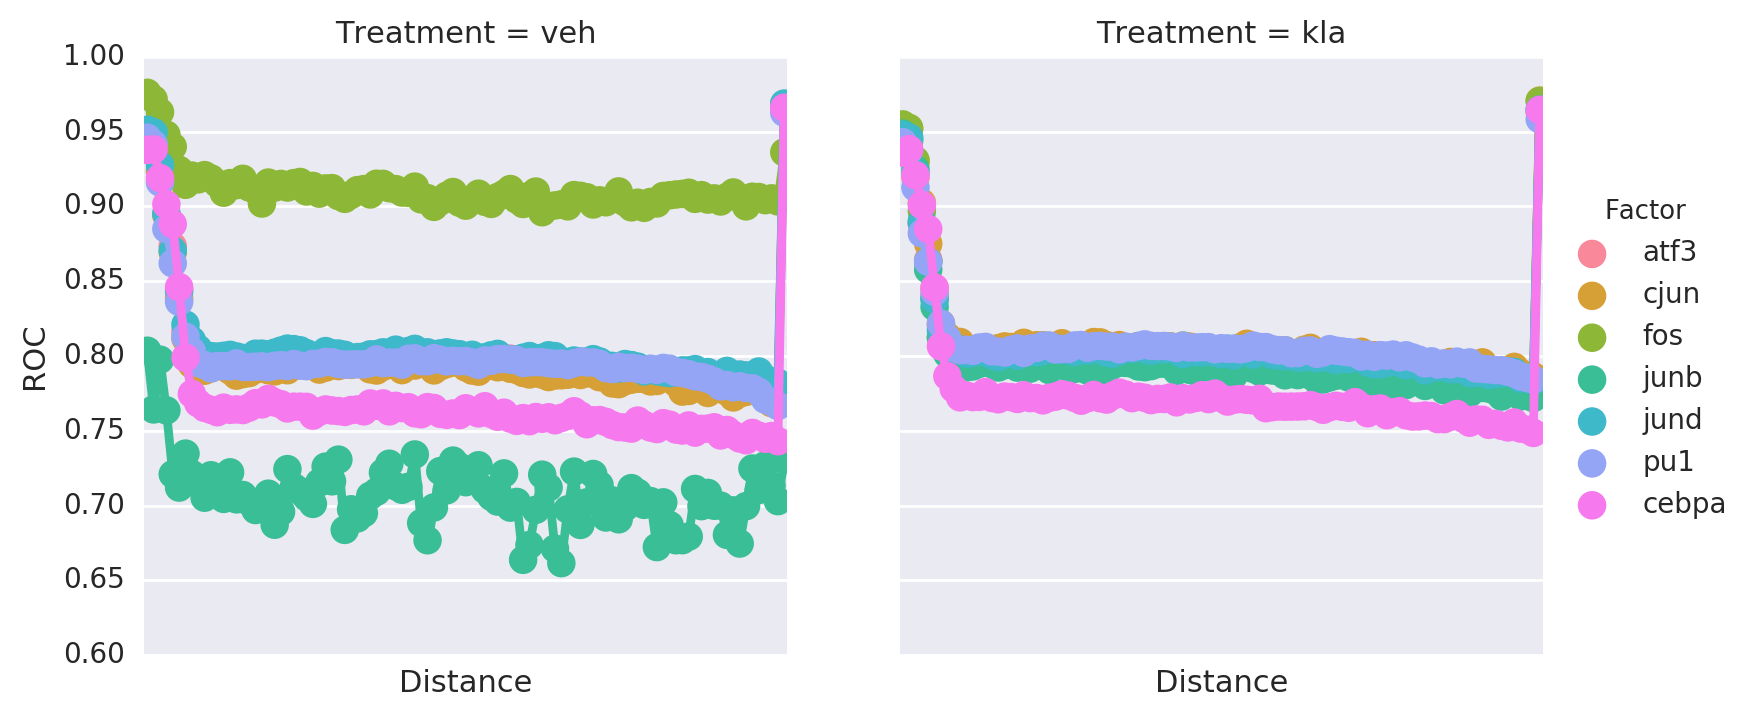

In [64]:
sns.factorplot(data=performance_frame,
              x = 'Distance',
              y='ROC',
              hue='Factor',
              col='Treatment')
plt.xticks([])


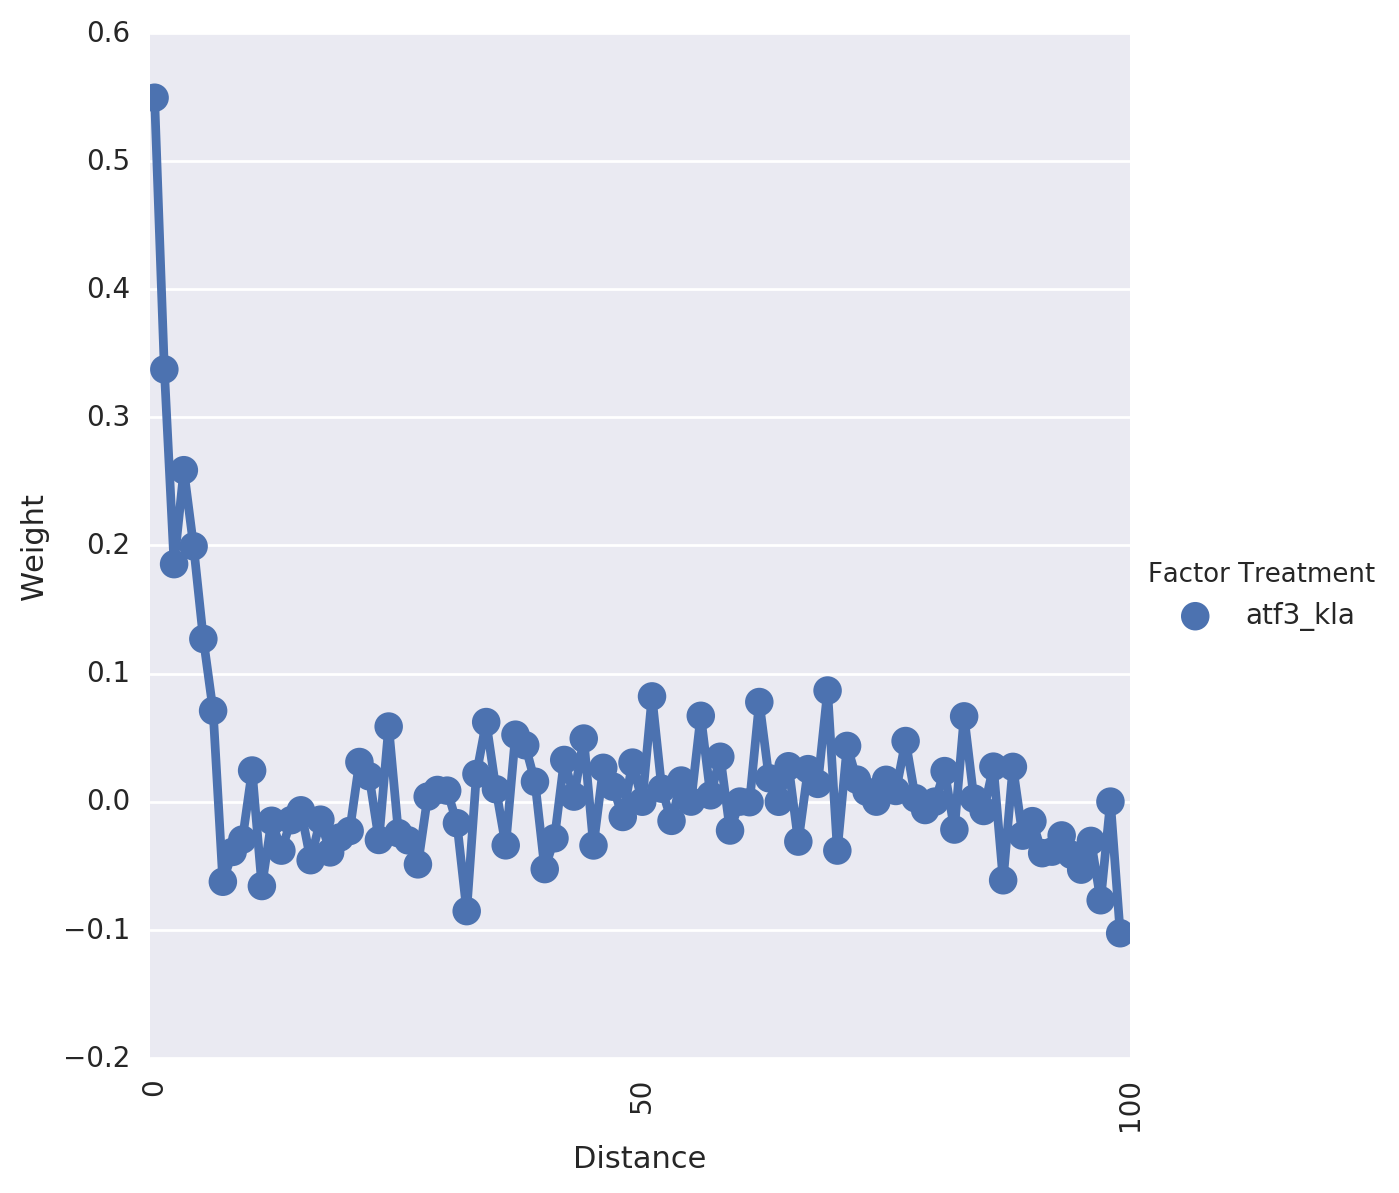

In [130]:
# average weights somehow...
factor_treatments = []
distances = []
weights = []
for factor_treatment in combined_weights_dict.keys():
    weights = weights + list(np.mean(combined_weights_dict[factor_treatment], axis=0))
    factor_treatments = factor_treatments + [factor_treatment] * 100
    distances = distances + list(range(100))
    

frame = pd.DataFrame({'Distance':distances, 'Weight':weights, 'Factor Treatment':factor_treatments})

sns.factorplot(data = frame[frame['Factor Treatment'] == 'atf3_kla'], 
               x='Distance', 
               y='Weight', 
               hue='Factor Treatment', 
               size=6,
              marker='.',
              s=0.1)
plt.xticks(rotation=90);
plt.xticks([0,50,100], [0,50,100]);

In [ ]:
interaction_distances = range(100)
for factor_treatment in combined_weights_dict.keys():
    mean_combined_weights = np.mean(combined_weights_dict[factor_treatment], axis=0)
    distance_weight_dict = dict(zip(interaction_distances, mean_combined_weights))
    individual_weights = []
    for dist in interaction_distances:
        mean_individual_weights = np.mean(interaction_weights_dict[factor_treatment][dist], axis=0)
        distance_weight = distance_weight_dict[dist]
        weighted_weights =  distance_weight * mean_individual_weights
        individual_weights.append(weighted_weights)
    individual_weights = np.array(individual_weights)
    
#     cg = sns.clustermap(individual_weights, 
#                     row_cluster=False,
#                     col_cluster=False,
#                     yticklabels=True, 
#                     xticklabels=False,
#                    vmax=0.04,
#                    vmin = -0.0
#                    )
#     plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=6, rotation=0);



    weight_threshold = 0.8
    data = pd.DataFrame(individual_weights, columns=range(4096))
    mins = data.min(axis=1)
    differences = data[[]]
    for col in data.columns:
        differences[col] = data[col].values - mins.values
    mins.sort()
    sorted_differences = differences.ix[mins.index.values,:]
#     cg = sns.clustermap(sorted_differences,
#                         col_cluster=False,
#                        row_cluster=False,
#                        cmap='Blues')
#     plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);
#     cg.ax_row_dendrogram.clear()
#     cg.ax_row_dendrogram.plot(sorted(mins, reverse=True), range(len(mins)))
#     cg.ax_row_dendrogram.set_yticks([])
# #     cg.ax_row_dendrogram.set_xlim(-6,6)
#     plt.suptitle(factor_treatment)
#     plt.show()


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:31: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


In [124]:
individual_weights.shape

(100, 4096)

In [127]:
mean_combined_weights.dot(individual_weights)

(1, 4096)